In [59]:
import pandas as pd
import numpy as np
import itertools
import math

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist

import seaborn as sns
import folium
from folium.plugins import HeatMap

#utils
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


#stat tools
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Sk Learn preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
#from sklearn.model_selection import GridSearchCV

# Keras Models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#from keras.layers import TimeDistributed
from keras.layers import Bidirectional
#from keras.layers import Flatten


from fbprophet import Prophet

plt.style.use('fivethirtyeight')


The following notebook contains the code used for the analysis and the graphs of the dataset. The full report is available in the files attached to this. The main purpose of these models is to be able to predict the net change of bikes at a station X at a given time Y.

To begin, let us load the data. Three dataset were provided to us. 
1. Station_data.csv - contains the general infomation about the stations, mainly their location, name, id and the amount of docks available at each
2. Trip_data.csv - contains information about the trips betweem various stations within the network. That include departure time, arrival time, stations Ids
3. Weather_data.csv - contains information about the weather at a given day

Let us load up the data and pull up some samples

In [3]:
# Loading the dataset
station_data = pd.read_csv("./data/station_data.csv")
trip_data = pd.read_csv("./data/trip_data.csv", parse_dates=['Start Date', 'End Date'])
weather_data = pd.read_csv("./data/weather_data.csv", parse_dates = ["Date"])

In [4]:
# Sample of stations data
station_data.head()


Id                               Name        Lat        Long  Dock Count  \
0   2  San Jose Diridon Caltrain Station  37.329732 -121.901782          27   
1   3              San Jose Civic Center  37.330698 -121.888979          15   
2   4             Santa Clara at Almaden  37.333988 -121.894902          11   
3   5                   Adobe on Almaden  37.331415 -121.893200          19   
4   6                   San Pedro Square  37.336721 -121.894074          15   

       City  
0  San Jose  
1  San Jose  
2  San Jose  
3  San Jose  
4  San Jose

In [5]:
# Sample of trip data
trip_data.head()

Trip ID          Start Date  Start Station            End Date  \
0   913460 2015-08-31 23:26:00             50 2015-08-31 23:39:00   
1   913459 2015-08-31 23:11:00             31 2015-08-31 23:28:00   
2   913455 2015-08-31 23:13:00             47 2015-08-31 23:18:00   
3   913454 2015-08-31 23:10:00             10 2015-08-31 23:17:00   
4   913453 2015-08-31 23:09:00             51 2015-08-31 23:22:00   

   End Station Subscriber Type  
0           70      Subscriber  
1           27      Subscriber  
2           64      Subscriber  
3            8      Subscriber  
4           60        Customer

In [6]:
# Sample of weather data
weather_data.head()

Date  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
0 2014-01-09              83.0               70.0              57.0   
1 2014-02-09              72.0               66.0              60.0   
2 2014-03-09              76.0               69.0              61.0   
3 2014-04-09              74.0               68.0              61.0   
4 2014-05-09              72.0               66.0              60.0   

   Max Dew PointF  MeanDew PointF  Min DewpointF  Max Humidity  Mean Humidity  \
0            58.0            56.0           52.0          86.0           64.0   
1            58.0            57.0           55.0          84.0           73.0   
2            57.0            56.0           55.0          84.0           69.0   
3            57.0            57.0           56.0          84.0           71.0   
4            57.0            56.0           54.0          84.0           71.0   

   Min Humidity  ...    Mean VisibilityMiles  Min VisibilityMiles  \
0          42.0  ...                    10.0                  8.0   
1          61.0  ...                    10.0                  7.0   
2          53.0  ...                    10.0                 10.0   
3          57.0  ...                    10.0                  8.0   
4          57.0  ...                     9.0                  7.0   

   Max Wind SpeedMPH  Mean Wind SpeedMPH  Max Gust SpeedMPH  PrecipitationIn  \
0               16.0                 7.0               20.0              0.0   
1               21.0                 8.0                NaN              0.0   
2               21.0                 8.0               24.0              0.0   
3               22.0                 8.0               25.0              0.0   
4               18.0                 8.0               32.0              0.0   

   CloudCover  Events  WindDirDegrees    Zip  
0         0.0     NaN           290.0  94107  
1         5.0     NaN           290.0  94107  
2         4.0     NaN           276.0  94107  
3         5.0     NaN           301.0  94107  
4         4.0     NaN           309.0  94107  

[5 rows x 24 columns]

 To begin with, there are spaces between the names of the variables. Let's replace them with a dash in order to make them more accessible. We have a decent amount of features to work with. To begin with, lets explore the individual datasets before merging everything into a single dataset that will be used later for prediction.

In [7]:
# Renaming columns for dot use
station_data.columns = station_data.columns.str.lower().str.replace(' ', '_')
trip_data.columns = trip_data.columns.str.lower().str.replace(' ', '_')
weather_data.columns = weather_data.columns.str.lower().str.replace(' ', '_')

# Exploration & Data Wrangling

### Station Dataset

In [8]:
# Checking type of variables
station_data.dtypes

id              int64
name           object
lat           float64
long          float64
dock_count      int64
city           object
dtype: object

In [9]:
# Make an empty map
m = folium.Map(location=[station_data['lat'].mean(), station_data['long'].mean()], 
               tiles="Mapbox Bright", 
               zoom_start=10)
# Creating locations for stations
stations_loc = [[float(station_data.lat.values[i]),float(station_data.long.values[i])] for i in range(len(station_data))]
# Placing stations on the map
m.add_child(HeatMap(stations_loc,radius=10))

In [10]:
station_data.dock_count.describe()


count    76.000000
mean     17.815789
std       4.015671
min      11.000000
25%      15.000000
50%      15.000000
75%      19.000000
max      27.000000
Name: dock_count, dtype: float64

First we need to check how the docks are distributed, most station will have about 20 or less docks. We can assume that the more docks a station has, the more popular it is. That means that the more docks a station has the more traffic it may or may not receive. Maybe this variable could be changed into a categorical one to feauture in the importance of station.

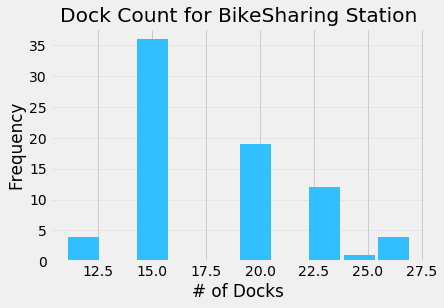

In [496]:
#Plot the number of docks per BikeSharing Stations
station_data.dock_count.hist(bins = 10, rwidth= 0.9, color = '#32bfff')
plt.title('Dock Count for BikeSharing Station')
plt.xlabel('# of Docks')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)


In [12]:
station_data.city.unique()


array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [495]:
# Plotting the number of stations per city 
station_data.groupby('city').size().plot.bar(title="# stations per city", 
                                             color=['#e5f7ff', '#ccefff', '#99dfff', '#66cfff', '#32bfff'])

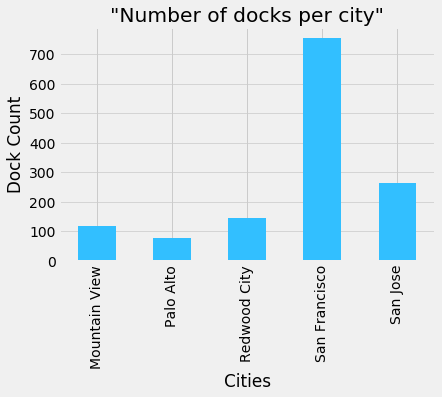

In [494]:
# Plotting the number of docks per city 
station_data.groupby('city').agg({'dock_count': 'sum'}).plot.bar(color= '#32bfff', legend = False,
                                                                )
plt.title('"Number of docks per city"')
plt.xlabel('Cities')
plt.ylabel('Dock Count')
plt.grid(axis='y', alpha=0.75)



### Trips

For the trip dataset, we have two datetime variables, 3 numerical variables, and one categorical. Let's create a new variable to estimate the lenght of each trip.

In [16]:
trip_data.dtypes

trip_id                     int64
start_date         datetime64[ns]
start_station               int64
end_date           datetime64[ns]
end_station                 int64
subscriber_type            object
dtype: object

To start with, we can go ahead and check the number of trips taken by type of subscribers. Not a lot of infos has been given about the meaning of this, so we will probably have to drop this column.

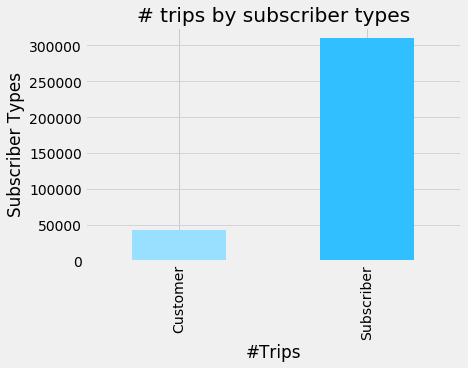

In [493]:
# Plotting the number of trips by subscriber type 
trip_data.groupby('subscriber_type').size().plot.bar(color=['#99dfff', '#32bfff'])
plt.title('# trips by subscriber types')
plt.xlabel('#Trips')
plt.ylabel('Subscriber Types')
plt.grid(axis='y', alpha=0.75)

In [17]:
# Creates the duration columns
trip_data['duration'] = trip_data.end_date - trip_data.start_date

Looking at the newly made duration column, we realize some inconsistency. One being the negative values and the other one being the lenght of the trips. These must be erronous data that need to be removed. 

In [18]:
trip_data.duration.describe()

count                    354152
mean     0 days 00:28:05.721949
std      2 days 12:21:52.813619
min         -320 days +12:50:00
25%             0 days 00:06:00
50%             0 days 00:09:00
75%             0 days 00:12:00
max           376 days 22:19:00
Name: duration, dtype: object

In [19]:
trip_data.duration.sort_values()

263390   -320 days +12:50:00
288250   -294 days +00:05:00
288251   -294 days +00:05:00
203326   -293 days +00:22:00
176696   -266 days +00:15:00
176701   -266 days +08:46:00
177204   -266 days +22:00:00
176874   -265 days +00:34:00
322470   -264 days +00:10:00
288784   -262 days +06:23:00
145776   -236 days +21:29:00
113966   -207 days +00:04:00
114088   -206 days +00:18:00
31905    -205 days +00:05:00
31904    -205 days +00:15:00
31906    -205 days +00:20:00
31913    -205 days +01:57:00
31914    -205 days +02:00:00
115818   -177 days +16:56:00
82936    -177 days +18:41:00
82603    -176 days +03:46:00
82619    -175 days +10:57:00
146811   -175 days +17:47:00
325175   -172 days +15:58:00
208711   -169 days +23:19:00
208714   -168 days +14:12:00
53947    -147 days +02:39:00
96328    -146 days +22:02:00
96342    -146 days +22:43:00
96355    -146 days +23:17:00
                 ...        
127985      37 days 01:47:00
319746      58 days 17:21:00
62608       58 days 21:51:00
280297      60

In [20]:
# Saving negative values in a new colums.
trip_data['neg'] = trip_data.duration < pd.Timedelta(0)
# Saving trips longer than 12 hours in another column.
trip_data['sup'] = trip_data.duration > pd.Timedelta(12, unit='h')

We have a about 650 out of 354 559 records that are wrong. These records are very few compared to the total amount of trips. Removing them will have an insignificant impact of the prediction.

In [21]:
trip_data.neg.value_counts()

False    354101
True         51
Name: neg, dtype: int64

In [22]:
trip_data.sup.value_counts()

False    353559
True        593
Name: sup, dtype: int64

In [23]:
# Saving the index of negative values.
drop_rows = trip_data[trip_data.neg == True ].index
#dropping negative values.
trip_data.drop(drop_rows , inplace=True)
# Saving the index of trips that are too long.
drop_rows = trip_data[trip_data.sup == True ].index
# dropping long trips.
trip_data.drop(drop_rows , inplace=True)
trip_data.drop(['sup', 'neg'], axis=1)

trip_id          start_date  start_station            end_date  \
0        913460 2015-08-31 23:26:00             50 2015-08-31 23:39:00   
1        913459 2015-08-31 23:11:00             31 2015-08-31 23:28:00   
2        913455 2015-08-31 23:13:00             47 2015-08-31 23:18:00   
3        913454 2015-08-31 23:10:00             10 2015-08-31 23:17:00   
4        913453 2015-08-31 23:09:00             51 2015-08-31 23:22:00   
5        913452 2015-08-31 23:07:00             68 2015-08-31 23:12:00   
6        913451 2015-08-31 23:07:00             51 2015-08-31 23:22:00   
7        913450 2015-08-31 22:16:00             60 2015-08-31 22:20:00   
8        913449 2015-08-31 22:12:00             56 2015-08-31 22:15:00   
9        913448 2015-08-31 21:57:00             47 2015-08-31 22:12:00   
10       913443 2015-08-31 21:49:00             60 2015-08-31 22:01:00   
11       913442 2015-08-31 21:44:00             67 2015-08-31 21:54:00   
12       913441 2015-08-31 21:39:00             76 2015-08-31 21:46:00   
13       913440 2015-08-31 21:31:00             77 2015-08-31 21:36:00   
14       913435 2015-08-31 21:25:00             55 2015-08-31 21:33:00   
15       913434 2015-08-31 21:19:00             88 2015-08-31 21:24:00   
16       913433 2015-08-31 21:17:00             35 2015-08-31 21:20:00   
17       913432 2015-08-31 21:16:00             87 2015-08-31 21:28:00   
18       913431 2015-08-31 21:11:00             55 2015-08-31 21:21:00   
19       913429 2015-08-31 21:07:00             70 2015-08-31 21:22:00   
20       913426 2015-08-31 21:06:00             70 2015-08-31 21:14:00   
21       913421 2015-08-31 21:01:00             28 2015-08-31 21:07:00   
22       913419 2015-08-31 20:58:00             74 2015-08-31 21:10:00   
23       913416 2015-08-31 20:53:00             68 2015-08-31 20:59:00   
24       913415 2015-08-31 20:53:00             50 2015-08-31 20:58:00   
25       913410 2015-08-31 20:46:00             60 2015-08-31 20:58:00   
26       913409 2015-08-31 20:44:00             87 2015-08-31 20:52:00   
27       913404 2015-08-31 20:39:00             88 2015-08-31 20:44:00   
28       913403 2015-08-31 20:37:00             77 2015-08-31 20:45:00   
29       913402 2015-08-31 20:36:00             67 2015-08-31 20:43:00   
...         ...                 ...            ...                 ...   
354122   433003 2014-01-09 09:30:00             84 2014-01-09 09:38:00   
354123   433002 2014-01-09 09:29:00             76 2014-01-09 16:05:00   
354124   433001 2014-01-09 09:29:00             76 2014-01-09 16:05:00   
354125   432999 2014-01-09 09:18:00             66 2014-01-09 09:29:00   
354126   432998 2014-01-09 09:16:00             67 2014-01-09 09:22:00   
354127   432996 2014-01-09 08:58:00             73 2014-01-09 09:05:00   
354128   432995 2014-01-09 08:55:00             71 2014-01-09 11:00:00   
354129   432994 2014-01-09 08:55:00             71 2014-01-09 11:00:00   
354130   432991 2014-01-09 08:49:00             76 2014-01-09 08:54:00   
354131   432985 2014-01-09 08:41:00             48 2014-01-09 08:48:00   
354132   432981 2014-01-09 08:31:00             76 2014-01-09 08:57:00   
354133   432980 2014-01-09 08:31:00             76 2014-01-09 08:57:00   
354134   432979 2014-01-09 08:30:00             42 2014-01-09 08:52:00   
354135   432978 2014-01-09 08:26:00             54 2014-01-09 08:36:00   
354136   432977 2014-01-09 08:24:00             67 2014-01-09 08:29:00   
354137   432972 2014-01-09 08:16:00             47 2014-01-09 10:12:00   
354138   432971 2014-01-09 08:12:00             74 2014-01-09 08:19:00   
354139   432967 2014-01-09 08:11:00             51 2014-01-09 08:14:00   
354140   432966 2014-01-09 07:37:00             27 2014-01-09 12:27:00   
354141   432965 2014-01-09 07:37:00             27 2014-01-09 12:25:00   
354142   432964 2014-01-09 07:32:00             54 2014-01-09 07:35:00   
354143   432960 2014-01-09 07:03:00              9 2014-01-09 08:38:00   
354144   432

Now that we have removed unneeded columns, we have values that are more realistic. The average trip last about a 13 mins, with the shortest trip being 1 min long  and the longest about 12 hours. 

In [24]:
trip_data.duration.describe()

count                    353508
mean     0 days 00:13:56.768559
std      0 days 00:33:01.409357
min             0 days 00:01:00
25%             0 days 00:06:00
50%             0 days 00:09:00
75%             0 days 00:12:00
max             0 days 11:59:00
Name: duration, dtype: object

Another interesting thing one can look at is how often a trip starts and ends at the same station. Since the logistics department is trying to figure out were to allocate their bikes, those trips that start and end at the same station might be irrelevant and if they do not constitute a large portion of the data (about 2.8%) we will remove them.

In [25]:
# Calculate the percentatage of trips that do not return to the same station.
same_station = (trip_data.start_station != trip_data.end_station).nonzero()[0]
print("The percentage of trips between stations is {:.3%}.".format(len(same_station)/len(trip_data)))

The percentage of trips between stations is 97.147%.


Now let's go ahead and join information about the station dataset and the trips dataset. Firts we duplicated the station dataset, in order to derive the outgoing and incomming information. In the columns down, 'out' stands for outgoing (eg. outgoing_city) and 'in' stands for incoming city.

In [ ]:
# Create new collumns giving information about incoming and outgoing stations.
start_stat=station_data.rename(columns=lambda s: f'out_{s}').set_index('out_id')
end_stat=station_data.rename(columns=lambda s: f'in_{s}').set_index('in_id')
trip_station = trip_data.join(start_stat, on='start_station').join(end_stat, on='end_station')

One thing that we realized on the map earlier is the fact that the stations are very clustered. One assumption one can make is that it's very unlikely that someone from San Franscico will ride all the way to Paolo Alto. We can quickly check how like it is for a rider to ride between cities. And if it is not as common, we can remove those trips in order to have highly clustered dataset.

We can realize that the precentage of those trips are about .14%, ergo removing them will have insignificant consequences on the dataset.

In [27]:
# Calculating the number of trips between different cities.
bet_city_trips=trip_station[trip_station.out_city != trip_station.in_city]
print("Number of intercity rents: {}".format(len(bet_city_trips.index))
print("The percentage of trips between different cities is {:.2%}.".format(len(intercity_trips)/len(trip_data)))

Number of intercity rents: 493
The percentage of trips between different cities is 0.14%.


In [28]:
# Removing trips between different cities.
drop_rows = bet_city_trips.index
trip_data.drop(drop_rows , inplace=True)

Let's go ahead and create new features. One intesting thing is to figure out the effect of holidays and the work days on the amount of bikes to be used. Indeed, some people might we using them a lot to go to work so let's go ahead and add in the business day. Adding the business day will additionnally reduce the complexity of the dataset as we do not have to add  the day of the week as a categorical variable, allowing us to generalize and reduce the complexity from 7 options to only 2. In addition to that we will add in the effect of holidays in the dataset.

In [32]:
#Find all the holidays in our dataset.
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=trip_station.start_date.min(), end=trip_station.end_date.max())

In [33]:
holidays

DatetimeIndex(['2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04',
               '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27',
               '2014-12-25', '2015-01-01', '2015-01-19', '2015-02-16',
               '2015-05-25', '2015-07-03', '2015-09-07', '2015-10-12',
               '2015-11-11', '2015-11-26'],
              dtype='datetime64[ns]', freq=None)

In [34]:
#Find all of the business days in our dataset.
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=trip_station.start_date.min(), end=trip_station.end_date.max(), freq=us_bd)

In [35]:
business_days

DatetimeIndex(['2014-01-09 00:05:00', '2014-01-10 00:05:00',
               '2014-01-13 00:05:00', '2014-01-14 00:05:00',
               '2014-01-15 00:05:00', '2014-01-16 00:05:00',
               '2014-01-17 00:05:00', '2014-01-21 00:05:00',
               '2014-01-22 00:05:00', '2014-01-23 00:05:00',
               ...
               '2015-11-24 00:05:00', '2015-11-25 00:05:00',
               '2015-11-27 00:05:00', '2015-11-30 00:05:00',
               '2015-12-01 00:05:00', '2015-12-02 00:05:00',
               '2015-12-03 00:05:00', '2015-12-04 00:05:00',
               '2015-12-07 00:05:00', '2015-12-08 00:05:00'],
              dtype='datetime64[ns]', length=481, freq='C')

In [36]:
# Reformatting to a pandas df.
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [37]:
business_days

array([datetime.date(2014, 1, 9), datetime.date(2014, 1, 10),
       datetime.date(2014, 1, 13), datetime.date(2014, 1, 14),
       datetime.date(2014, 1, 15), datetime.date(2014, 1, 16),
       datetime.date(2014, 1, 17), datetime.date(2014, 1, 21),
       datetime.date(2014, 1, 22), datetime.date(2014, 1, 23),
       datetime.date(2014, 1, 24), datetime.date(2014, 1, 27),
       datetime.date(2014, 1, 28), datetime.date(2014, 1, 29),
       datetime.date(2014, 1, 30), datetime.date(2014, 1, 31),
       datetime.date(2014, 2, 3), datetime.date(2014, 2, 4),
       datetime.date(2014, 2, 5), datetime.date(2014, 2, 6),
       datetime.date(2014, 2, 7), datetime.date(2014, 2, 10),
       datetime.date(2014, 2, 11), datetime.date(2014, 2, 12),
       datetime.date(2014, 2, 13), datetime.date(2014, 2, 14),
       datetime.date(2014, 2, 18), datetime.date(2014, 2, 19),
       datetime.date(2014, 2, 20), datetime.date(2014, 2, 21),
       datetime.date(2014, 2, 24), datetime.date(2014, 2, 25)

In [38]:
# Adding the new feature in our dataset as a boolean variable.
trip_station['is_bus_day'] = trip_station.start_date.dt.date.isin(business_days)
trip_station['is_holiday'] = trip_station.start_date.dt.date.isin(holidays)


In [39]:
print('There are {} business days.'.format(len(trip_station.start_date.dt.date[trip_station.is_bus_day==True].unique())))
print('There are {} holidays.'.format(len(trip_station.start_date.dt.date[trip_station.is_holiday==True].unique())))
print('There are totally {} days.'.format(len(trip_station.start_date.dt.date.unique())))

There are 250 business days in the record.
There are 10 holidays in the record.
There are totally 365 days in the record.


Now, we should go ahead and wrangle the data set to its final format. First we need to count the amount of trips incoming to the station and outgoing from the station. The later is very useful as it will allow us later on to establish the demand for bikes at a particular station. But since the net change is what is expected to be predicted, let's focus this notebook on predicting that target variable. Let's first filter out the incoming out and outgoing trips from various stations per hour.

In [40]:
# Create a dataframe for incoming trips to a particular station.
trips_in = trip_station[['end_date', 'end_station', 'in_city', 'is_bus_day', 'is_holiday']].copy()
# Counts the number of trips incoming to a station per hour.
trips_in['incoming_count'] = ''
trips_in = trips_in.groupby([pd.TimeGrouper('H', key='end_date'), 
                  pd.Grouper(key ='end_station'),'in_city', 'is_bus_day', 'is_holiday'])['incoming_count'].count()


C:\Users\ngoro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
# Create a dataframe for outgoing trips from a particular station.
trips_out = trip_station[['start_date', 'start_station','out_city', 'is_bus_day', 'is_holiday']].copy()
# Counts the number of trips incoming to a station per hour.
trips_out['outgoing_count'] = ''
trips_out = trips_out.groupby([pd.TimeGrouper('H', key='start_date'), 
                  pd.Grouper(key ='start_station'), 'out_city', 'is_bus_day', 'is_holiday'])['outgoing_count'].count()

C:\Users\ngoro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


Now that we have the count of the incoming and outgoing trips per hour per station. Let us combine those count into a new dataframe and add in a new feature 'net'; which will correspond to our target variable. Indeed, the net will be the variable we need to predict and is going to be the difference between the outgoing count and the incoming count at a time t and a station X.

In [43]:
# Create new dataframe for trips count and net change.
df_new = ''
trips_in =  pd.DataFrame(trips_in)
trips_out = pd.DataFrame(trips_out)
# Add incoming and outgoing trips toguether
df_new =pd.concat([trips_in, trips_out], axis=1)
df_new =df_new.fillna(0)
# Create the new net feature.
df_new['net'] = df_new.outgoing_count - df_new.incoming_count
# Since most columns ended up being in index, we renamed them.
df_new.index = df_new.index.set_names(['date', 'station', 'city', 'is_bus_day', 'is_holiday'])
# Remove columns not useful as index from index.
df_new.reset_index(level=['city','is_bus_day', 'is_holiday'], inplace= True)
df_new

city  is_bus_day  is_holiday  \
date                station                                          
2014-01-09 00:00:00 57       San Francisco        True       False   
                    66       San Francisco        True       False   
2014-01-09 03:00:00 50       San Francisco        True       False   
2014-01-09 04:00:00 39       San Francisco        True       False   
                    65       San Francisco        True       False   
                    66       San Francisco        True       False   
2014-01-09 05:00:00 68       San Francisco        True       False   
                    70       San Francisco        True       False   
                    72       San Francisco        True       False   
2014-01-09 06:00:00 67       San Francisco        True       False   
                    74       San Francisco        True       False   
2014-01-09 07:00:00 9             San Jose        True       False   
                    27       Mountain View        True       False   
                    51       San Francisco        True       False   
                    54       San Francisco        True       False   
                    77       San Francisco        True       False   
2014-01-09 08:00:00 9             San Jose        True       False   
                    39       San Francisco        True       False   
                    42       San Francisco        True       False   
                    47       San Francisco        True       False   
                    48       San Francisco        True       False   
                    50       San Francisco        True       False   
                    51       San Francisco        True       False   
                    54       San Francisco        True       False   
                    60       San Francisco        True       False   
                    67       San Francisco        True       False   
                    70       San Francisco        True       False   
                    71       San Francisco        True       False   
                    73       San Francisco        True       False   
                    74       San Francisco        True       False   
...                                    ...         ...         ...   
2015-12-08 22:00:00 2             San Jose        True       False   
                    9             San Jose        True       False   
                    27       Mountain View        True       False   
                    28       Mountain View        True       False   
                    39       San Francisco        True       False   
                    51       San Francisco        True       False   
                    54       San Francisco        True       False   
                    56       San Francisco        True       False   
                    57       San Francisco        True       False   
                    59       San Francisco        True       False   
                    60       San Francisco        True       False   
                    65       San Francisco        True       False   
                    66       San Francisco        True       False   
                    67       San Francisco        True       False   
                    70       San Francisco        True       False   
                    71       San Francisco        True       False   
                    74       San Francisco        True       False   
                    87       San Francisco        True       False   
                    88       San Francisco        True       False   
2015-12-08 23:00:00 39       San Francisco        True       False   
                    42       San Francisco        True       False   
                    45       San Francisco        True       False   
                    46       San Francisco        True       False   
                    54       San Francisco        True       False   
                    57       San Francisco      

### Weather

Now that we have created one part of the main dataset, we can go ahead and process the weather data. Looking at the types of variable, we realize that most of the are float number except one. This suggest that almost all of those variable are numberical. Let's process the data. 

In [44]:
weather_data.dtypes

date                         datetime64[ns]
max_temperaturef                    float64
mean_temperaturef                   float64
min_temperaturef                    float64
max_dew_pointf                      float64
meandew_pointf                      float64
min_dewpointf                       float64
max_humidity                        float64
mean_humidity                       float64
min_humidity                        float64
max_sea_level_pressurein            float64
mean_sea_level_pressurein           float64
min_sea_level_pressurein            float64
max_visibilitymiles                 float64
mean_visibilitymiles                float64
min_visibilitymiles                 float64
max_wind_speedmph                   float64
mean_wind_speedmph                  float64
max_gust_speedmph                   float64
precipitationin                     float64
cloudcover                          float64
events                               object
winddirdegrees                  

We can observe that their are a lot of missing data. Since they are weather data, we can just replace the missing values with the weather of the previous day, since as assume the weather today is most of the time somewhat similar to the weather the previous day.

In [45]:
weather_data.isna().sum()

date                            0
max_temperaturef                4
mean_temperaturef               4
min_temperaturef                4
max_dew_pointf                 50
meandew_pointf                 50
min_dewpointf                  50
max_humidity                   50
mean_humidity                  50
min_humidity                   50
max_sea_level_pressurein        1
mean_sea_level_pressurein       1
min_sea_level_pressurein        1
max_visibilitymiles             5
mean_visibilitymiles            5
min_visibilitymiles             5
max_wind_speedmph               1
mean_wind_speedmph              1
max_gust_speedmph             541
precipitationin                 1
cloudcover                      1
events                       1538
winddirdegrees                  1
zip                             0
dtype: int64

First let's replace the zip values with the actual name of the town. The relation Zip to City was provided to us in the project description. We will use the city name to merge the weather dataset with our main dataset later on.

In [46]:
weather_data.zip.unique()

array([94107, 94063, 94301, 94041, 95113], dtype=int64)

In [47]:
# Create the zit to city relationship
zip_to_city = dict()
zip_to_city[94107] = 'San Francisco'
zip_to_city[94063] = 'Redwood City'
zip_to_city[94301] = 'Palo Alto'
zip_to_city[94041] = 'Mountain View'
zip_to_city[95113] = 'San Jose'

In [48]:
# Change the zip code to the city name.
weather_data["city"] = weather_data.zip.apply(lambda x:zip_to_city[x])

We have a lot of missing values in the event column. Since it is a categorical variable, let's see the type of events included.

In [49]:
weather_data.events.unique()

array([nan, 'Rain', 'Fog', 'Fog-Rain', 'Rain-Thunderstorm'], dtype=object)

We have 4 types of category and a missing value. Since the missing values constitute a large part of the dataset, I assume the events get to receive a value only during Rain, Fog , Fog-Rain and Thunderstorm. If these events do not happen, that variable is left empty. Consequently, instead of deleting it, what we can do is replace those 'nan' with 'sunny', creating ergo a new category. In addition to that, let's go ahead and dummify the even column by transforming it to a bool variable. This will improve our model later on.

In [50]:
# Replacing missing with sunny 
weather_data.loc[weather_data.events.isnull(), 'events'] = "Sunny"

In [51]:
# Creating dummies for the event column
weather_data = weather_data.merge(pd.get_dummies(weather_data.events), left_index = True, right_index = True)

In [52]:
weather_data.isna().sum()

date                           0
max_temperaturef               4
mean_temperaturef              4
min_temperaturef               4
max_dew_pointf                50
meandew_pointf                50
min_dewpointf                 50
max_humidity                  50
mean_humidity                 50
min_humidity                  50
max_sea_level_pressurein       1
mean_sea_level_pressurein      1
min_sea_level_pressurein       1
max_visibilitymiles            5
mean_visibilitymiles           5
min_visibilitymiles            5
max_wind_speedmph              1
mean_wind_speedmph             1
max_gust_speedmph            541
precipitationin                1
cloudcover                     1
events                         0
winddirdegrees                 1
zip                            0
city                           0
Fog                            0
Fog-Rain                       0
Rain                           0
Rain-Thunderstorm              0
Sunny                          0
dtype: int

We have a lot of missing values for the max_gust_speed too. We could simply replace those with the mean. As for the rest of the missings we will simply replace them with the conditions of the previous day.

In [53]:
# Replacing max gust speed missing with the mean_wind_speed.
weather_data.loc[weather_data.max_gust_speedmph.isna(), 'max_gust_speedmph'] = weather_data.groupby('max_wind_speedmph').max_gust_speedmph.apply(lambda x: x.fillna(x.median()))

In [54]:
# Replacing missing values with the conditions the previous day.
weather_data.fillna(method='ffill', inplace=True)

In [55]:
# Double checking for missing values.
weather_data.isna().sum()

date                         0
max_temperaturef             0
mean_temperaturef            0
min_temperaturef             0
max_dew_pointf               0
meandew_pointf               0
min_dewpointf                0
max_humidity                 0
mean_humidity                0
min_humidity                 0
max_sea_level_pressurein     0
mean_sea_level_pressurein    0
min_sea_level_pressurein     0
max_visibilitymiles          0
mean_visibilitymiles         0
min_visibilitymiles          0
max_wind_speedmph            0
mean_wind_speedmph           0
max_gust_speedmph            0
precipitationin              0
cloudcover                   0
events                       0
winddirdegrees               0
zip                          0
city                         0
Fog                          0
Fog-Rain                     0
Rain                         0
Rain-Thunderstorm            0
Sunny                        0
dtype: int64

In [56]:
# Dropping event column and the zip code because we do not need them.
weather_data = weather_data.drop(['events','zip'],1)
weather_data= weather_data.rename(columns={'date': 'dat'})

### Creating Final Dataset

Now we can go ahead and create our final dataset that we will use for modeling. One major problem with the dataset is the presence of gaps between events (start or end of ride). Those gaps will turn this problem in to a survival time serie problem. Ergo as we create and merge the final dataset for each station, we will need to fill up the gaps with 0 to demonstrate that there were no activities during a particular time. For example given a station X, let say a pick up happens at 01:00 (net change: -1), and the the next pick up happens at 08:00 (net_change: -1); we will need to fill up the gap between those 2 events per hour and adding a net change of 0 . 

The frequency of those gaps are going to be per hour since it is a requirement in the project description. In addition to that, we need to change the old station names to their new ones, as indicated in the project description.

Variable names : t = temporary; ts= tempory_station ; trys = temporary_current_station

In [57]:
# Create temporary dataset.
t = df_new.copy()
t= t.reset_index()
# Set date as index.
t= t.set_index(['date'])
# Replaced the station old station names by new ones.
t.station = t['station'].replace({23: 85, 25: 86, 49: 88, 69 : 88, 72 : 89})
# Creating a station list.
stations = list(t.station.unique())

In [60]:
ts = pd.DataFrame()
for station in tqdm(stations):
    # Selecting records for a station.
    trys = t.loc[t['station'] == station].copy()
    trys = trys[~trys.index.duplicated(keep='last')]
    # Fill the gaps on hourly basis.
    trys = trys.asfreq('H')
    # Fill na with current station and city.
    trys.station = trys.station.ffill()
    trys.city = trys.city.ffill()
    # Add in the current date (to be used in merging with weather).
    trys['dat']= pd.to_datetime(trys.index, format='%Y/%m/%d').date
    # Check for business day or holiday.
    trys['is_bus_day'] = trys.dat.isin(business_days)
    trys['is_holiday'] = trys.dat.isin(holidays)
    # Fill the rest (incoming, outgoing and net) with 0.
    trys = trys.fillna(0)
    # Add new processed station to final dataset
    ts = pd.concat([ts, trys])
    

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  3.89it/s]


In [62]:
ts['dat'] = pd.to_datetime(ts.dat)
ts.reset_index()
ts.head()

station           city  is_bus_day  is_holiday  \
date                                                                  
2014-01-09 00:00:00     57.0  San Francisco        True       False   
2014-01-09 01:00:00     57.0  San Francisco        True       False   
2014-01-09 02:00:00     57.0  San Francisco        True       False   
2014-01-09 03:00:00     57.0  San Francisco        True       False   
2014-01-09 04:00:00     57.0  San Francisco        True       False   

                     incoming_count  outgoing_count  net        dat  
date                                                                 
2014-01-09 00:00:00             3.0             0.0 -3.0 2014-01-09  
2014-01-09 01:00:00             0.0             0.0  0.0 2014-01-09  
2014-01-09 02:00:00             0.0             0.0  0.0 2014-01-09  
2014-01-09 03:00:00             0.0             0.0  0.0 2014-01-09  
2014-01-09 04:00:00             0.0             0.0  0.0 2014-01-09

Now that we have everything set up we can go ahead and merge the net count by station per hour with the weather variable. Merging will we done by date and city since they are the two features common to both dataset.

In [63]:
data= pd.merge(ts, weather_data, on=['dat','city'], how='left').set_index(ts.index)

In [64]:
# Changing bool to 0 and 1
data.is_bus_day = data.is_bus_day.astype(int)
data.is_holiday = data.is_holiday.astype(int)
data.head()


station           city  is_bus_day  is_holiday  \
date                                                                  
2014-01-09 00:00:00     57.0  San Francisco           1           0   
2014-01-09 01:00:00     57.0  San Francisco           1           0   
2014-01-09 02:00:00     57.0  San Francisco           1           0   
2014-01-09 03:00:00     57.0  San Francisco           1           0   
2014-01-09 04:00:00     57.0  San Francisco           1           0   

                     incoming_count  outgoing_count  net        dat  \
date                                                                  
2014-01-09 00:00:00             3.0             0.0 -3.0 2014-01-09   
2014-01-09 01:00:00             0.0             0.0  0.0 2014-01-09   
2014-01-09 02:00:00             0.0             0.0  0.0 2014-01-09   
2014-01-09 03:00:00             0.0             0.0  0.0 2014-01-09   
2014-01-09 04:00:00             0.0             0.0  0.0 2014-01-09   

                     max_temperaturef  mean_temperaturef  ...    \
date                                                      ...     
2014-01-09 00:00:00              83.0               70.0  ...     
2014-01-09 01:00:00              83.0               70.0  ...     
2014-01-09 02:00:00              83.0               70.0  ...     
2014-01-09 03:00:00              83.0               70.0  ...     
2014-01-09 04:00:00              83.0               70.0  ...     

                     mean_wind_speedmph  max_gust_speedmph  precipitationin  \
date                                                                          
2014-01-09 00:00:00                 7.0               20.0              0.0   
2014-01-09 01:00:00                 7.0               20.0              0.0   
2014-01-09 02:00:00                 7.0               20.0              0.0   
2014-01-09 03:00:00                 7.0               20.0              0.0   
2014-01-09 04:00:00                 7.0               20.0              0.0   

                     cloudcover  winddirdegrees  Fog  Fog-Rain  Rain  \
date                                                                   
2014-01-09 00:00:00         0.0           290.0  0.0       0.0   0.0   
2014-01-09 01:00:00         0.0           290.0  0.0       0.0   0.0   
2014-01-09 02:00:00         0.0           290.0  0.0       0.0   0.0   
2014-01-09 03:00:00         0.0           290.0  0.0       0.0   0.0   
2014-01-09 04:00:00         0.0           290.0  0.0       0.0   0.0   

                     Rain-Thunderstorm  Sunny  
date                                           
2014-01-09 00:00:00                0.0    1.0  
2014-01-09 01:00:00                0.0    1.0  
2014-01-09 02:00:00                0.0    1.0  
2014-01-09 03:00:00                0.0    1.0  
2014-01-09 04:00:00                0.0    1.0  

[5 rows x 34 columns]

We have about 22 features in our final data set. We will now separate the numerical and categorical features from each other.

In [65]:
data.columns

Index(['station', 'city', 'is_bus_day', 'is_holiday', 'incoming_count',
       'outgoing_count', 'net', 'dat', 'max_temperaturef', 'mean_temperaturef',
       'min_temperaturef', 'max_dew_pointf', 'meandew_pointf', 'min_dewpointf',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressurein', 'mean_sea_level_pressurein',
       'min_sea_level_pressurein', 'max_visibilitymiles',
       'mean_visibilitymiles', 'min_visibilitymiles', 'max_wind_speedmph',
       'mean_wind_speedmph', 'max_gust_speedmph', 'precipitationin',
       'cloudcover', 'winddirdegrees', 'Fog', 'Fog-Rain', 'Rain',
       'Rain-Thunderstorm', 'Sunny'],
      dtype='object')

In [66]:
# Separating numerical and categorical variables
data_num = ['max_temperaturef',
       'mean_temperaturef', 'min_temperaturef', 'max_dew_pointf',
       'meandew_pointf', 'min_dewpointf', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_visibilitymiles',
       'mean_visibilitymiles', 'min_visibilitymiles', 'max_wind_speedmph',
       'mean_wind_speedmph', 'max_gust_speedmph', 'precipitationin',
       'cloudcover', 'net']

data_cat = ['city', 'is_bus_day', 'is_holiday', 'winddirdegrees', 'Fog', 'Fog-Rain', 'Rain',
       'Rain-Thunderstorm', 'Sunny']


In [66]:
stations = data.station.unique()
len(stations)
stations

array([57., 66., 50., 39., 65., 68., 70., 89., 67., 74.,  9., 27., 51.,
       54., 77., 42., 47., 48., 60., 71., 73., 76.,  3., 46., 61., 63.,
       88., 84., 13., 28., 32., 41., 45., 59., 75.,  8., 34., 58., 64.,
        2.,  6., 16., 82., 31., 56.,  7., 55., 62., 14., 33., 12., 30.,
       36.,  4., 10., 22., 86.,  5., 11., 26., 29., 80., 37., 35., 85.,
       38., 24., 83., 21., 87., 90.])

Since we have a lot of variable, we can see how they relate to each other through a correlation matrix.That way if there exist strong relation between certain features and our target variable, we could forcus our attention more on those. We picked the data from one station since it will mimic the same behavior with the other stations. 

Unfortunately, in our case the net change does not seem to be highly correlated with any variable. Which means that we will be using most of the features for prediction. In addition to that, we will be dropping the max_sea_level, mean_sea_level and min_sea_level pressure, since they seem to be negatively correlated with the other features.

In [68]:
# Compute the correlation matrix.
# pick data from one station.
corr_all = data.loc[data['station'] == 57].drop(['city'], axis = 1).corr()
# Initialize the figure.
f, ax = plt.subplots(figsize = (11, 9))
# Add in the correlation heatmap
sns.heatmap(corr_all, mask = mask,
            square = False, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

Now let's go ahead and plot the histogram for the numerical features in our dataset. One thing that we realize in that plot, is that most of the numerical data have a normal shape. This is good in a sense that it increase their chance to be stationary variable.  The concept of stationarity means that the data generation process does not change. (mean median not increasing/decreasing over time). We will test that theory later on.

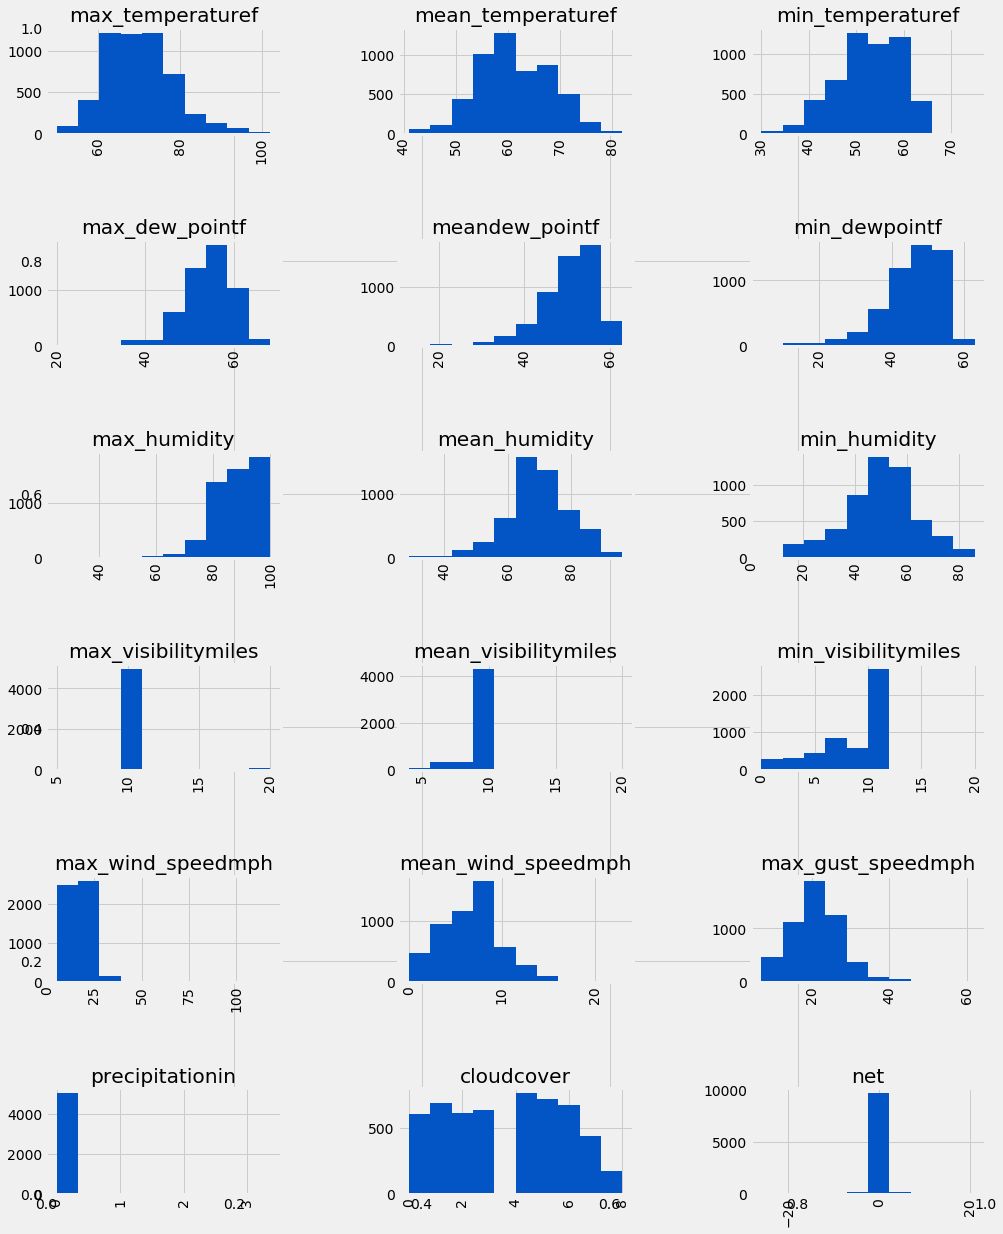

In [70]:
fig, axes = plt.subplots(figsize=(15,20))
rows = 6
cols = 3
for i, e in enumerate(data_num):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(e)
    data[e].sample(10000).hist(axes=ax, color = '#0354c4')
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [71]:
data = data.drop(['max_sea_level_pressurein', 'mean_sea_level_pressurein',
       'min_sea_level_pressurein'], 1)

Let us see, if there exist any thing interesting that we can pickup based on the daily net change for each stations. One thing to realize is that for most station from Jan-2014 to Oct-2014, we can observe some gaps with some distinctive spikes on most station, this may be due so seasonality but they do not happen the following year. We do not have enough information to draw a proper conclusion. After those dates the daily usage seems to be fluctuating differently for each station.

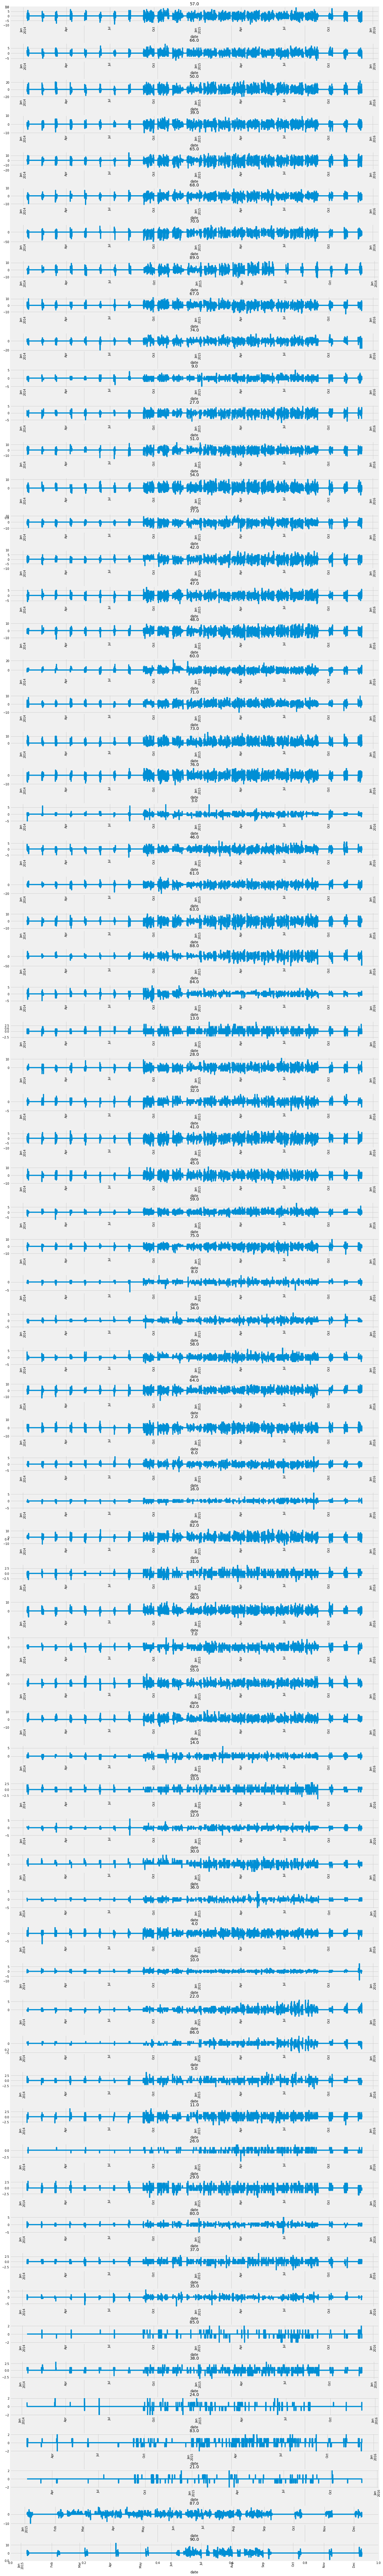

In [100]:
fig, axes = plt.subplots(figsize=(20,160))
rows = 71
cols = 1
for i, e in enumerate(stations):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(e)
    data.loc[data['station'] == e].net.plot()
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

Since we could not pick up any similar behavior using the daily values, we group them by weekly values, and unfortunately, we could not find any similar thrend between variable from different station. One thing that we picked up though, is for some station there is an increase in activity during late spring and summer rather that the rest of the other months. 

In [79]:
#checks the seasonality weekly
fig, axes = plt.subplots(figsize=(20,200))
rows = 71
cols = 1
for i, e in enumerate(stations):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title('station #' + str(e))
    data.loc[data['station'] == e].net.resample('W').sum().plot()
    plt.xlabel('')
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=1.1, wspace=0.5)
plt.show()

Like the seasonality, no clear trend could be established between the variables. One observation, like the seasonality, for some stations, there is an increased activity during the summer and late spring rather that fall and winter.


In [82]:
# Checks for trend
fig, axes = plt.subplots(figsize=(20,200))
rows = 71
cols = 1
for i, e in enumerate(stations):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title('station #' + str(e))
    decomposition = seasonal_decompose(data.loc[data['station'] == e].net, model = 'additive', freq = 365)
    decomposition.trend.plot(ax = ax)
    plt.xlabel('')
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=1)
plt.show()

Looking at the autocorrelation graph, we notice a highly similar increase at lag = 0, and a increase at lag 24 and 48 for all variables.

In [83]:
#cheking for autocorrelation
fig, axes = plt.subplots(figsize=(20,200))
rows = 71
cols = 1
for i, e in enumerate(stations):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(e)
    plot_acf(data.loc[data['station'] == e].net, lags = 50, ax = ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.5)
plt.show()

Now lets check how stationary the features are.To do that we will be using the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test which figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root. A stationary time series is one where statistical properties — like the mean and variance — are constant over time. Namely, if the test statistics is above a critical value, the serie is not stationary.

We will go trough every numerical value for every station and save the feautures that are not stationary. If there exist any, we will apply a logarithmic differenciation to that column in other to make it stationary.

In [84]:
#define KPSS
def kpss_test(timeseries):
    kpsstest = kpss(timeseries, regression='c')
    # Save the various critical values
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    dict(kpss_output)
    #compare test statistics with critical value
    if kpss_output['Test Statistic'] > kpss_output['Critical Value (10%)']:
        return (True)


In [420]:
# Save the non stationary series in dictionary
non_stationary = {}
for station in tqdm(stations):
    for e in data_num:
        cols = []
        if (kpss_test(data.loc[data['station'] == station][e]) == True):
            cols.append(e)
    non_stationary[station] = cols
non_stationary        

  0%|                                                                                           | 0/71 [00:00<?, ?it/s]C:\Users\ngoro\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
  1%|█▏                                                                                 | 1/71 [00:00<00:23,  2.92it/s]C:\Users\ngoro\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:20<00:00,  3.86it/s]


{2: [],
 3: [],
 4: [],
 5: [],
 6: ['net'],
 7: ['net'],
 8: ['net'],
 9: ['net'],
 10: [],
 11: ['net'],
 12: ['net'],
 13: ['net'],
 14: [],
 16: ['net'],
 21: [],
 22: ['net'],
 24: [],
 26: ['net'],
 27: [],
 28: ['net'],
 29: [],
 30: ['net'],
 31: [],
 32: [],
 33: [],
 34: ['net'],
 35: [],
 36: [],
 37: [],
 38: ['net'],
 39: ['net'],
 41: ['net'],
 42: ['net'],
 45: ['net'],
 46: ['net'],
 47: ['net'],
 48: ['net'],
 50: [],
 51: [],
 54: ['net'],
 55: ['net'],
 56: ['net'],
 57: [],
 58: ['net'],
 59: ['net'],
 60: ['net'],
 61: ['net'],
 62: ['net'],
 63: ['net'],
 64: ['net'],
 65: ['net'],
 66: ['net'],
 67: ['net'],
 68: ['net'],
 70: ['net'],
 71: ['net'],
 73: ['net'],
 74: [],
 75: ['net'],
 76: [],
 77: ['net'],
 80: ['net'],
 82: [],
 83: ['net'],
 84: ['net'],
 85: ['net'],
 86: ['net'],
 87: ['net'],
 88: ['net'],
 89: ['net'],
 90: ['net']}

According to the test, all the other features are non stationary, ergo we will need to make them stationary by applying a logarithmic differentiation. We will do that later in the pipeline. Unfortunately the log-diff applies only for positive values, ergo we will not be applying it to the net change.

# Model Definition

Now it's time to define the model to be used. One thing that we realize previously is that it was hard to find any trend or seasonality with the dataset that we have. This is maybe due to the fact that we are working with hourly data containing a lot of gaps as opposed to monthly data spread in years. In addition to that the net change of certain of our stations are not stationary, which will reduce the predictive accuracy of certain univariate model. Those fact would rule out the use of ARMA or VARMAX model. We will instead focuss on the use of RNN.

Since we have a mutivariate setting, we could use all of those feautures as input features. We will train one different lstm for each station. The evaluation metrics that is going to be used is the Root Mean Squared Error (RMSE) which gives error in the same units as the variable itself. We will calculate the RMSE for each station an save it. The type of LSTM that will be used is the simple LSTM, the Bidirectional LSTM (and maybe a stacked one). 

Once we collect the results for the LSTM, we will try the univariate approach by fitting the net change on Facebook prophet forecaster.

In [483]:
#@memory.cache()
def get_data(data, station, subset='train', uni = 0 ):
    '''
        Extract the test, train data
    '''

    if (subset == 'train'):
        if(uni == 0):
            # Select data for a particular stations.
            station_data = data.loc[data['station'] == station]
            # Remove not needed columns.
            station_data = station_data.drop(['station', 'city', 'dat', 'incoming_count',
           'outgoing_count'],1)
            # Select y_train and X_train date range.
            y = station_data.net[:'2015-07-06 18:00:00']
            station_data = station_data.drop(['net'],1)
            X = station_data[:'2015-07-06 18:00:00']
            return X, y
        else:
            # return y_train for the univariate model.
            station_data = data.loc[data['station'] == station]
            y = station_data.net[:'2015-07-06 18:00:00']
            return y
    if (subset == 'test'):
        if (uni == 0):
            # Select data from a station.
            station_data = data.loc[data['station'] == station]
            # Remove not needed columns.
            station_data = station_data.drop(['station', 'city', 'dat', 'incoming_count',
           'outgoing_count'],1)
            # Select y_test and X_test date range.
            y = station_data.net['2015-07-06 18:00:00':]
            station_data = station_data.drop(['net'],1)
            X = station_data['2015-07-06 18:00:00':]        
            return X, y
        else:
            # Return y_test for the univariate model.
            station_data = data.loc[data['station'] == station]
            y = station_data.net['2015-07-06 18:00:00':]
            return y

def forecast_prophet(data, holiday):
    '''
        Returns the RMSE of the a prophet forecaster
        
        Parameters :
            data ~ pandas Dataframe
            holiday ~ pandas series corresponding to date of holidays
    '''
    results = {}
    # Set up the holiday variable in prophet format.
    prophet_holidays = pd.DataFrame(holidays, columns=['ds'])
    holi =pd.DataFrame({'holiday': 'holiday',
                      'ds': pd.to_datetime(prophet_holidays['ds'])})
    prophet_holidays.head()
    # Extract the various stations.
    stations = data.station.unique()
    for station in tqdm(stations):  
        y_train = pd.DataFrame(get_data(data, station, 'train', 1))
        # Set up uncertainty interval, in our case .95.
        my_model = Prophet(interval_width = 0.95, 
                   holidays = holi)
        # Set up training data in prophet format.
        y_train = y_train.reset_index()
        y_train = y_train.rename(columns = {'date': 'ds',
                                             'net': 'y'})
        # Fit the model.
        my_model.fit(y_train)
        # Set up test data in prophet format.
        y_test = pd.DataFrame(get_data(data, 57, 'test', 1))
        y_test =  y_test.reset_index()
        y_test =  y_test.rename(columns = {'date': 'ds',
                                            'net': 'y'})
        # Create future prediction Date.
        future = pd.DataFrame(y_test['ds'])
        # Predict future dataframe
        forecast = my_model.predict(future)
        y_pred = forecast.yhat
        # Save the RMSE between predicted values and actual values
        results[station] = math.sqrt(mean_squared_error(y_test.y, y_pred))
    return results

def score_solution_rnn(data, model, save = 0):
    '''
    Return RMSE of a RNN.
    
    Parameters:
        data ~  pandas dataset
        model ~ hold a classification model 
        save ~ Flag used to save the best model on file using jobLib
    '''
    results = {}
    stations = data.station.unique()
    for station in tqdm(stations):  
        # Reinitialize Pipeline.
        pipeline = ''
        X_train, y_train = get_data(data, station, subset='train')
        # Change categorical columns as category for Pipeline.
        for f in data_cat:
            X_train[f] = X_train[f].astype("category")
        # Create new pipeline and fit data.
        pipeline = get_pipeline(model, X_train.columns)
        pipeline.fit(X_train, y_train)
        # Get the test dataset.
        X_test, y_test = get_data(data, station, subset='test')
        # Change categorical columns as category for Pipeline.
        for f in data_cat:
            X_test[f] = X_test[f].astype("category")
        # Apply the model to the test DataFrame.
        y_pred = pipeline.predict(X_test)
        # Evaluate the predictions with RMSE.
        if (save==1): joblib.dump(pipeline, 'Best_Estimator.sav')
        print(math.sqrt(mean_squared_error(y_test, y_pred)))
        results[station] = math.sqrt(mean_squared_error(y_test, y_pred))
    return results

def get_pipeline(model, x_cols):
    '''
    Fit a model to a SK_learn Pipeline
    
    Parameters:
        model ~ Custom Transformer corresponding to the model we want to train
        x_cols ~ Array like variable corresponding to the features for X_train
    '''
    # Creating a preprocessing pipeline.        
    preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
    # Numerical pipeline Pipeline.
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            Imputer(strategy="median"),
            StandardScaler()
        )),
    # Categorical Pipeline
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            Imputer(strategy="most_frequent"),
        ))
     ])
     )
    # Classifier Pipeline
    classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    reshape_RNN(),
    model
    )
    return classifier_pipeline
    pass

# ------------ CUSTOM TRANSFORMERS ----------
class sk_RNN(BaseEstimator, RegressorMixin):
    '''
    Wrap a Keras LSTM Classifier to be used in model
    Parameters fixed
    '''
    def __init__(self):
        #initialize Simple LSTM
        self.model = Sequential()
    
    def fit(self, X, y):
        # Adding various layers.
        self.model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
        self.model.add(Dense(1))
        # Setting up keras compiler.
        self.model.compile(loss='mse', optimizer='adam')
        # Fitting the model.
        self.model.fit(X, y, epochs=50, batch_size=72, validation_split= 0.1, verbose=0, shuffle=False)
        return self.model

    def predict(self, X):
        # Make Simple LSTM Preciction
        return self.model.predict(X)

class stacked_RNN(BaseEstimator, RegressorMixin):
    '''
    Wrap a Keras Stacked LSTM Classifier to be used in model
    Parameters fixed
    '''
    def __init__(self):
        return None
    
    def fit(self, X, y):
        self.model = Sequential()
        # Adding various layers.
        self.model.add(LSTM(50, return_sequences=True), input_shape=(X.shape[1], X.shape[2]))
        self.model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
        self.model.add(Dense(1))
        # Setting up Keras Compiler.
        self.model.compile(loss='mse', optimizer='adam')
        # Fit the model.
        self.model.fit(X, y, epochs=50, batch_size=72, validation_split= 0.1, verbose=0, shuffle=False)
        return self.model

    def predict(self, X):
        # Make stacked LSTM prediction
        return self.model.predict(X)

class Bidirectional_RNN(BaseEstimator, RegressorMixin):
    '''
    Wrap a Keras Bidirectional LSTM Classifier to be used in model
    Parameters fixed
    '''
    def __init__(self):
        return None
    
    def fit(self, X, y):
        # Adding various layers.
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
        self.model.add(Flatten())
        self.model.add(Dense(1))
        # Setting up Keras Compiler.
        self.model.compile(loss='mse', optimizer='adam')
        # Fit the model.
        self.model.fit(X, y, epochs=50, batch_size=72, validation_split= 0.1, verbose=2, shuffle=False)
        return self.model

    def predict(self, X):
        # Make Bidirectional LSTM prediction
        return self.model.predict(X)
    
class reshape_RNN(BaseEstimator, TransformerMixin):
    '''
     Reshaped numpy array from 2-dim to 3-dim
     Parameters fixed
    '''
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        shape = X.reshape((X.shape[0], 1, X.shape[1]))
        return shape


class ColumnSelector(BaseEstimator, TransformerMixin):
    '''
    Pull collumn of interest from the dataframe.
    Parameters fixed
    '''
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

class TypeSelector(BaseEstimator, TransformerMixin):
    '''
    Select Collumns based on the dtypes
    Parameter fixed
    '''
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

PS: I usually keep the above on separate files but due to the requirements of the project description, I have decided to keep all code within one notebook.

# Results

1. Results Bidirectional LSTM

The data took approximatively 2 hours to train. We obtained a RMSE of 0.9155 which is very acceptable. That means that the prediction were off by about a bike give or take, which will clearly enough for the logistic department to know which station needs more or less bikes at time X. We observed RMSE as lo as 0.07 for certain stations and as high as 4.6 for other, which increased the main rmse. However, about 50# of the stations had a RMSE close to 0.7

In [485]:
res_Bi_RNN = score_solution_rnn(data, Bidirectional_RNN())


  0%|                                                                                           | 0/71 [00:00<?, ?it/s]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11745 samples, validate on 1306 samples
Epoch 1/50


 - 9s - loss: 1.1101 - val_loss: 1.4660
Epoch 2/50
 - 1s - loss: 1.0817 - val_loss: 1.4653
Epoch 3/50
 - 1s - loss: 1.0801 - val_loss: 1.4659
Epoch 4/50
 - 1s - loss: 1.0781 - val_loss: 1.4653
Epoch 5/50
 - 1s - loss: 1.0784 - val_loss: 1.4655
Epoch 6/50
 - 1s - loss: 1.0773 - val_loss: 1.4652
Epoch 7/50
 - 1s - loss: 1.0771 - val_loss: 1.4653
Epoch 8/50
 - 1s - loss: 1.0771 - val_loss: 1.4648
Epoch 9/50
 - 1s - loss: 1.0764 - val_loss: 1.4647
Epoch 10/50
 - 1s - loss: 1.0774 - val_loss: 1.4658
Epoch 11/50
 - 1s - loss: 1.0774 - val_loss: 1.4656
Epoch 12/50
 - 1s - loss: 1.0767 - val_loss: 1.4669
Epoch 13/50
 - 1s - loss: 1.0765 - val_loss: 1.4651
Epoch 14/50
 - 1s - loss: 1.0762 - val_loss: 1.4653
Epoch 15/50
 - 1s - loss: 1.0763 - val_loss: 1.4657
Epoch 16/50
 - 1s - loss: 1.0767 - val_loss: 1.4654
Epoch 17/50
 - 1s - loss: 1.0767 - val_loss: 1.4654
Epoch 18/50
 - 1s - loss: 1.0758 - val_loss: 1.4661
Epoch 19/50
 - 1s - loss: 1.0751 - val_loss: 1.4658
Epoch 20/50
 - 1s - loss: 1.0750

  1%|█▏                                                                               | 1/71 [00:54<1:03:15, 54.22s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11745 samples, validate on 1306 samples
Epoch 1/50
 - 9s - loss: 0.6797 - val_loss: 1.2254
Epoch 2/50
 - 1s - loss: 0.6813 - val_loss: 1.2263
Epoch 3/50
 - 1s - loss: 0.6831 - val_loss: 1.2253
Epoch 4/50
 - 1s - loss: 0.6794 - val_loss: 1.2253
Epoch 5/50
 - 1s - loss: 0.6786 - val_loss: 1.2252
Epoch 6/50
 - 1s - loss: 0.6783 - val_loss: 1.2247
Epoch 7/50
 - 1s - loss: 0.6782 - val_loss: 1.2246
Epoch 8/50
 - 1s - loss: 0.6781 - val_loss: 1.2248
Epoch 9/50
 - 1s - loss: 0.6781 - val_loss: 1.2248
Epoch 10/50
 - 1s - loss: 0.6780 - val_loss: 1.2249
Epoch 11/50
 - 1s - loss: 0.6779 - val_loss: 1.2255
Epoch 12/50
 - 1s - loss: 0.6779 - val_loss: 1.2255
Epoch 13/50
 - 1s - loss: 0.6779 - val_loss: 1.2257
Epoch 14/50
 - 1s - loss: 0.6779 - val_loss: 1.2261
Epoch 15/50
 - 1s - loss: 0.6780 - val_loss: 1.2265
Epoch 16/50
 - 1s - loss: 0.6786 - val_loss: 1.2258
Epoch 17/50
 - 1s - loss: 0.6782 - val_loss: 1.2268
Epoch 18/50
 - 1s - loss: 0.6774 - val_loss: 1.2270
Epoch 19/50
 - 1s - loss

  3%|██▎                                                                              | 2/71 [01:53<1:04:04, 55.72s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11743 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 5.9988 - val_loss: 12.5915
Epoch 2/50
 - 1s - loss: 5.9822 - val_loss: 12.5913
Epoch 3/50
 - 1s - loss: 5.9842 - val_loss: 12.5922
Epoch 4/50
 - 1s - loss: 5.9854 - val_loss: 12.5911
Epoch 5/50
 - 1s - loss: 5.9812 - val_loss: 12.5916
Epoch 6/50
 - 1s - loss: 5.9802 - val_loss: 12.5913
Epoch 7/50
 - 1s - loss: 5.9794 - val_loss: 12.5911
Epoch 8/50
 - 1s - loss: 5.9788 - val_loss: 12.5911
Epoch 9/50
 - 1s - loss: 5.9785 - val_loss: 12.5911
Epoch 10/50
 - 1s - loss: 5.9782 - val_loss: 12.5911
Epoch 11/50
 - 1s - loss: 5.9780 - val_loss: 12.5912
Epoch 12/50
 - 1s - loss: 5.9781 - val_loss: 12.5908
Epoch 13/50
 - 1s - loss: 5.9765 - val_loss: 12.5940
Epoch 14/50
 - 1s - loss: 5.9804 - val_loss: 12.5940
Epoch 15/50
 - 1s - loss: 5.9796 - val_loss: 12.5910
Epoch 16/50
 - 1s - loss: 5.9783 - val_loss: 12.5908
Epoch 17/50
 - 1s - loss: 5.9776 - val_loss: 12.5920
Epoch 18/50
 - 1s - loss: 5.9781 - val_loss: 12.5904
Epoch

  4%|███▍                                                                             | 3/71 [02:49<1:03:17, 55.85s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11742 samples, validate on 1305 samples
Epoch 1/50
 - 14s - loss: 1.2950 - val_loss: 2.3449
Epoch 2/50
 - 1s - loss: 1.2709 - val_loss: 2.3451
Epoch 3/50
 - 1s - loss: 1.2696 - val_loss: 2.3449
Epoch 4/50
 - 1s - loss: 1.2676 - val_loss: 2.3451
Epoch 5/50
 - 1s - loss: 1.2665 - val_loss: 2.3443
Epoch 6/50
 - 1s - loss: 1.2660 - val_loss: 2.3443
Epoch 7/50
 - 1s - loss: 1.2659 - val_loss: 2.3444
Epoch 8/50
 - 1s - loss: 1.2659 - val_loss: 2.3442
Epoch 9/50
 - 1s - loss: 1.2658 - val_loss: 2.3443
Epoch 10/50
 - 1s - loss: 1.2666 - val_loss: 2.3444
Epoch 11/50
 - 1s - loss: 1.2660 - val_loss: 2.3439
Epoch 12/50
 - 1s - loss: 1.2660 - val_loss: 2.3443
Epoch 13/50
 - 1s - loss: 1.2661 - val_loss: 2.3441
Epoch 14/50
 - 1s - loss: 1.2663 - val_loss: 2.3442
Epoch 15/50
 - 1s - loss: 1.2660 - val_loss: 2.3445
Epoch 16/50
 - 1s - loss: 1.2670 - val_loss: 2.3443
Epoch 17/50
 - 1s - loss: 1.2663 - val_loss: 2.3443
Epoch 18/50
 - 1s - loss: 1.2670 - val_loss: 2.3435
Epoch 19/50
 - 1s - los

  6%|████▌                                                                            | 4/71 [03:48<1:03:17, 56.68s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11742 samples, validate on 1305 samples
Epoch 1/50
 - 8s - loss: 3.7903 - val_loss: 8.0477
Epoch 2/50
 - 1s - loss: 3.8005 - val_loss: 8.0417
Epoch 3/50
 - 1s - loss: 3.7945 - val_loss: 8.0412
Epoch 4/50
 - 1s - loss: 3.7918 - val_loss: 8.0411
Epoch 5/50
 - 1s - loss: 3.7907 - val_loss: 8.0403
Epoch 6/50
 - 1s - loss: 3.7905 - val_loss: 8.0407
Epoch 7/50
 - 1s - loss: 3.7901 - val_loss: 8.0411
Epoch 8/50
 - 1s - loss: 3.7896 - val_loss: 8.0409
Epoch 9/50
 - 1s - loss: 3.7895 - val_loss: 8.0414
Epoch 10/50
 - 1s - loss: 3.7898 - val_loss: 8.0431
Epoch 11/50
 - 1s - loss: 3.7894 - val_loss: 8.0425
Epoch 12/50
 - 1s - loss: 3.7881 - val_loss: 8.0430
Epoch 13/50
 - 1s - loss: 3.7881 - val_loss: 8.0410
Epoch 14/50
 - 1s - loss: 3.7891 - val_loss: 8.0430
Epoch 15/50
 - 1s - loss: 3.7902 - val_loss: 8.0426
Epoch 16/50
 - 1s - loss: 3.7898 - val_loss: 8.0444
Epoch 17/50
 - 1s - loss: 3.7886 - val_loss: 8.0421
Epoch 18/50
 - 1s - loss: 3.7889 - val_loss: 8.0430
Epoch 19/50
 - 1s - loss

  7%|█████▋                                                                           | 5/71 [04:40<1:00:48, 55.28s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11741 samples, validate on 1305 samples
Epoch 1/50
 - 8s - loss: 1.1214 - val_loss: 1.7769
Epoch 2/50
 - 1s - loss: 1.1223 - val_loss: 1.7754
Epoch 3/50
 - 1s - loss: 1.1253 - val_loss: 1.7753
Epoch 4/50
 - 1s - loss: 1.1197 - val_loss: 1.7753
Epoch 5/50
 - 1s - loss: 1.1180 - val_loss: 1.7751
Epoch 6/50
 - 1s - loss: 1.1176 - val_loss: 1.7755
Epoch 7/50
 - 1s - loss: 1.1175 - val_loss: 1.7754
Epoch 8/50
 - 1s - loss: 1.1176 - val_loss: 1.7753
Epoch 9/50
 - 1s - loss: 1.1169 - val_loss: 1.7752
Epoch 10/50
 - 1s - loss: 1.1169 - val_loss: 1.7753
Epoch 11/50
 - 1s - loss: 1.1167 - val_loss: 1.7753
Epoch 12/50
 - 1s - loss: 1.1167 - val_loss: 1.7750
Epoch 13/50
 - 1s - loss: 1.1175 - val_loss: 1.7757
Epoch 14/50
 - 1s - loss: 1.1165 - val_loss: 1.7752
Epoch 15/50
 - 1s - loss: 1.1168 - val_loss: 1.7753
Epoch 16/50
 - 1s - loss: 1.1163 - val_loss: 1.7755
Epoch 17/50
 - 1s - loss: 1.1169 - val_loss: 1.7752
Epoch 18/50
 - 1s - loss: 1.1169 - val_loss: 1.7757
Epoch 19/50
 - 1s - loss

  8%|███████                                                                            | 6/71 [05:32<58:58, 54.44s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11741 samples, validate on 1305 samples
Epoch 1/50
 - 8s - loss: 22.9082 - val_loss: 30.7697
Epoch 2/50
 - 1s - loss: 22.9534 - val_loss: 30.7612
Epoch 3/50
 - 1s - loss: 22.9302 - val_loss: 30.7673
Epoch 4/50
 - 1s - loss: 22.9392 - val_loss: 30.7474
Epoch 5/50
 - 1s - loss: 22.9397 - val_loss: 30.7325
Epoch 6/50
 - 1s - loss: 22.8754 - val_loss: 30.7745
Epoch 7/50
 - 1s - loss: 22.9098 - val_loss: 30.7710
Epoch 8/50
 - 1s - loss: 22.9143 - val_loss: 30.7540
Epoch 9/50
 - 1s - loss: 22.9094 - val_loss: 30.7600
Epoch 10/50
 - 1s - loss: 22.9230 - val_loss: 30.7545
Epoch 11/50
 - 1s - loss: 22.9236 - val_loss: 30.7873
Epoch 12/50
 - 1s - loss: 22.9033 - val_loss: 30.7602
Epoch 13/50
 - 1s - loss: 22.8942 - val_loss: 30.7605
Epoch 14/50
 - 1s - loss: 22.9176 - val_loss: 30.7779
Epoch 15/50
 - 1s - loss: 22.8771 - val_loss: 30.7422
Epoch 16/50
 - 1s - loss: 22.9062 - val_loss: 30.7195
Epoch 17/50
 - 1s - loss: 22.9100 - val_loss: 30.7534
Epoch 18/50
 - 1s - loss: 22.8979 - val_lo

 10%|████████▏                                                                          | 7/71 [06:28<58:36, 54.94s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11741 samples, validate on 1305 samples
Epoch 1/50
 - 9s - loss: 1.5431 - val_loss: 2.0424
Epoch 2/50
 - 1s - loss: 1.5435 - val_loss: 2.0268
Epoch 3/50
 - 1s - loss: 1.5462 - val_loss: 2.0245
Epoch 4/50
 - 1s - loss: 1.5414 - val_loss: 2.0272
Epoch 5/50
 - 1s - loss: 1.5415 - val_loss: 2.0242
Epoch 6/50
 - 1s - loss: 1.5393 - val_loss: 2.0399
Epoch 7/50
 - 1s - loss: 1.5419 - val_loss: 2.0240
Epoch 8/50
 - 1s - loss: 1.5399 - val_loss: 2.0240
Epoch 9/50
 - 1s - loss: 1.5397 - val_loss: 2.0249
Epoch 10/50
 - 1s - loss: 1.5402 - val_loss: 2.0239
Epoch 11/50
 - 1s - loss: 1.5398 - val_loss: 2.0239
Epoch 12/50
 - 1s - loss: 1.5393 - val_loss: 2.0245
Epoch 13/50
 - 1s - loss: 1.5394 - val_loss: 2.0250
Epoch 14/50
 - 1s - loss: 1.5393 - val_loss: 2.0253
Epoch 15/50
 - 1s - loss: 1.5394 - val_loss: 2.0248
Epoch 16/50
 - 1s - loss: 1.5392 - val_loss: 2.0247
Epoch 17/50
 - 1s - loss: 1.5412 - val_loss: 2.0244
Epoch 18/50
 - 1s - loss: 1.5405 - val_loss: 2.0244
Epoch 19/50
 - 1s - loss

 11%|█████████▎                                                                         | 8/71 [07:23<57:29, 54.76s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11740 samples, validate on 1305 samples
Epoch 1/50
 - 8s - loss: 1.8882 - val_loss: 3.3195
Epoch 2/50
 - 1s - loss: 1.8501 - val_loss: 3.3213
Epoch 3/50
 - 1s - loss: 1.8467 - val_loss: 3.3196
Epoch 4/50
 - 1s - loss: 1.8433 - val_loss: 3.3225
Epoch 5/50
 - 1s - loss: 1.8392 - val_loss: 3.3221
Epoch 6/50
 - 1s - loss: 1.8378 - val_loss: 3.3229
Epoch 7/50
 - 1s - loss: 1.8370 - val_loss: 3.3233
Epoch 8/50
 - 1s - loss: 1.8382 - val_loss: 3.3236
Epoch 9/50
 - 1s - loss: 1.8350 - val_loss: 3.3233
Epoch 10/50
 - 1s - loss: 1.8354 - val_loss: 3.3231
Epoch 11/50
 - 1s - loss: 1.8343 - val_loss: 3.3246
Epoch 12/50
 - 1s - loss: 1.8344 - val_loss: 3.3235
Epoch 13/50
 - 1s - loss: 1.8345 - val_loss: 3.3237
Epoch 14/50
 - 1s - loss: 1.8341 - val_loss: 3.3234
Epoch 15/50
 - 1s - loss: 1.8346 - val_loss: 3.3256
Epoch 16/50
 - 1s - loss: 1.8329 - val_loss: 3.3220
Epoch 17/50
 - 1s - loss: 1.8325 - val_loss: 3.3219
Epoch 18/50
 - 1s - loss: 1.8311 - val_loss: 3.3248
Epoch 19/50
 - 1s - loss

 13%|██████████▌                                                                        | 9/71 [08:15<55:45, 53.97s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11740 samples, validate on 1305 samples
Epoch 1/50
 - 9s - loss: 2.2881 - val_loss: 3.7657
Epoch 2/50
 - 1s - loss: 2.2857 - val_loss: 3.7651
Epoch 3/50
 - 1s - loss: 2.2919 - val_loss: 3.7645
Epoch 4/50
 - 1s - loss: 2.2808 - val_loss: 3.7645
Epoch 5/50
 - 1s - loss: 2.2796 - val_loss: 3.7644
Epoch 6/50
 - 1s - loss: 2.2792 - val_loss: 3.7642
Epoch 7/50
 - 1s - loss: 2.2788 - val_loss: 3.7642
Epoch 8/50
 - 1s - loss: 2.2785 - val_loss: 3.7642
Epoch 9/50
 - 1s - loss: 2.2783 - val_loss: 3.7643
Epoch 10/50
 - 1s - loss: 2.2781 - val_loss: 3.7641
Epoch 11/50
 - 1s - loss: 2.2778 - val_loss: 3.7642
Epoch 12/50
 - 1s - loss: 2.2777 - val_loss: 3.7640
Epoch 13/50
 - 1s - loss: 2.2775 - val_loss: 3.7639
Epoch 14/50
 - 1s - loss: 2.2773 - val_loss: 3.7637
Epoch 15/50
 - 1s - loss: 2.2771 - val_loss: 3.7638
Epoch 16/50
 - 1s - loss: 2.2772 - val_loss: 3.7639
Epoch 17/50
 - 1s - loss: 2.2774 - val_loss: 3.7636
Epoch 18/50
 - 1s - loss: 2.2780 - val_loss: 3.7639
Epoch 19/50
 - 1s - loss

 14%|███████████▌                                                                      | 10/71 [09:17<57:29, 56.54s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11739 samples, validate on 1305 samples
Epoch 1/50
 - 9s - loss: 0.1110 - val_loss: 0.2684
Epoch 2/50
 - 1s - loss: 0.1036 - val_loss: 0.2685
Epoch 3/50
 - 1s - loss: 0.1029 - val_loss: 0.2678
Epoch 4/50
 - 1s - loss: 0.1027 - val_loss: 0.2680
Epoch 5/50
 - 1s - loss: 0.1026 - val_loss: 0.2679
Epoch 6/50
 - 1s - loss: 0.1025 - val_loss: 0.2678
Epoch 7/50
 - 1s - loss: 0.1025 - val_loss: 0.2677
Epoch 8/50
 - 1s - loss: 0.1025 - val_loss: 0.2676
Epoch 9/50
 - 1s - loss: 0.1025 - val_loss: 0.2676
Epoch 10/50
 - 1s - loss: 0.1026 - val_loss: 0.2676
Epoch 11/50
 - 1s - loss: 0.1026 - val_loss: 0.2675
Epoch 12/50
 - 1s - loss: 0.1027 - val_loss: 0.2676
Epoch 13/50
 - 1s - loss: 0.1028 - val_loss: 0.2674
Epoch 14/50
 - 1s - loss: 0.1026 - val_loss: 0.2678
Epoch 15/50
 - 1s - loss: 0.1026 - val_loss: 0.2675
Epoch 16/50
 - 1s - loss: 0.1025 - val_loss: 0.2675
Epoch 17/50
 - 1s - loss: 0.1025 - val_loss: 0.2674
Epoch 18/50
 - 1s - loss: 0.1025 - val_loss: 0.2674
Epoch 19/50
 - 1s - loss

 15%|████████████▋                                                                     | 11/71 [10:10<55:20, 55.34s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11739 samples, validate on 1305 samples
Epoch 1/50
 - 9s - loss: 0.2770 - val_loss: 0.7111
Epoch 2/50
 - 1s - loss: 0.2650 - val_loss: 0.7104
Epoch 3/50
 - 1s - loss: 0.2639 - val_loss: 0.7101
Epoch 4/50
 - 1s - loss: 0.2636 - val_loss: 0.7099
Epoch 5/50
 - 1s - loss: 0.2632 - val_loss: 0.7100
Epoch 6/50
 - 1s - loss: 0.2631 - val_loss: 0.7099
Epoch 7/50
 - 1s - loss: 0.2630 - val_loss: 0.7100
Epoch 8/50
 - 1s - loss: 0.2631 - val_loss: 0.7110
Epoch 9/50
 - 1s - loss: 0.2642 - val_loss: 0.7100
Epoch 10/50
 - 1s - loss: 0.2630 - val_loss: 0.7095
Epoch 11/50
 - 1s - loss: 0.2633 - val_loss: 0.7114
Epoch 12/50
 - 1s - loss: 0.2637 - val_loss: 0.7104
Epoch 13/50
 - 1s - loss: 0.2640 - val_loss: 0.7102
Epoch 14/50
 - 1s - loss: 0.2632 - val_loss: 0.7099
Epoch 15/50
 - 1s - loss: 0.2628 - val_loss: 0.7097
Epoch 16/50
 - 1s - loss: 0.2628 - val_loss: 0.7102
Epoch 17/50
 - 1s - loss: 0.2626 - val_loss: 0.7101
Epoch 18/50
 - 1s - loss: 0.2626 - val_loss: 0.7101
Epoch 19/50
 - 1s - loss

 17%|█████████████▊                                                                    | 12/71 [11:04<54:08, 55.05s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11739 samples, validate on 1305 samples
Epoch 1/50
 - 9s - loss: 2.0718 - val_loss: 3.6651
Epoch 2/50
 - 1s - loss: 2.0757 - val_loss: 3.6581
Epoch 3/50
 - 1s - loss: 2.0722 - val_loss: 3.6603
Epoch 4/50
 - 1s - loss: 2.0686 - val_loss: 3.6598
Epoch 5/50
 - 1s - loss: 2.0665 - val_loss: 3.6623
Epoch 6/50
 - 1s - loss: 2.0684 - val_loss: 3.6623
Epoch 7/50
 - 1s - loss: 2.0667 - val_loss: 3.6585
Epoch 8/50
 - 1s - loss: 2.0656 - val_loss: 3.6593
Epoch 9/50
 - 1s - loss: 2.0648 - val_loss: 3.6581
Epoch 10/50
 - 1s - loss: 2.0651 - val_loss: 3.6593
Epoch 11/50
 - 1s - loss: 2.0643 - val_loss: 3.6603
Epoch 12/50
 - 1s - loss: 2.0650 - val_loss: 3.6606
Epoch 13/50
 - 1s - loss: 2.0664 - val_loss: 3.6574
Epoch 14/50
 - 1s - loss: 2.0644 - val_loss: 3.6571
Epoch 15/50
 - 1s - loss: 2.0653 - val_loss: 3.6575
Epoch 16/50
 - 1s - loss: 2.0649 - val_loss: 3.6565
Epoch 17/50
 - 1s - loss: 2.0651 - val_loss: 3.6566
Epoch 18/50
 - 1s - loss: 2.0641 - val_loss: 3.6572
Epoch 19/50
 - 1s - loss

 18%|███████████████                                                                   | 13/71 [11:57<52:41, 54.50s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11739 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 1.4412 - val_loss: 2.7197
Epoch 2/50
 - 1s - loss: 1.3927 - val_loss: 2.7202
Epoch 3/50
 - 1s - loss: 1.3920 - val_loss: 2.7213
Epoch 4/50
 - 1s - loss: 1.3922 - val_loss: 2.7205
Epoch 5/50
 - 1s - loss: 1.3909 - val_loss: 2.7215
Epoch 6/50
 - 1s - loss: 1.3899 - val_loss: 2.7209
Epoch 7/50
 - 1s - loss: 1.3901 - val_loss: 2.7207
Epoch 8/50
 - 1s - loss: 1.3891 - val_loss: 2.7211
Epoch 9/50
 - 1s - loss: 1.3891 - val_loss: 2.7214
Epoch 10/50
 - 1s - loss: 1.3894 - val_loss: 2.7214
Epoch 11/50
 - 1s - loss: 1.3889 - val_loss: 2.7216
Epoch 12/50
 - 1s - loss: 1.3889 - val_loss: 2.7218
Epoch 13/50
 - 1s - loss: 1.3878 - val_loss: 2.7220
Epoch 14/50
 - 1s - loss: 1.3891 - val_loss: 2.7221
Epoch 15/50
 - 1s - loss: 1.3882 - val_loss: 2.7226
Epoch 16/50
 - 1s - loss: 1.3885 - val_loss: 2.7242
Epoch 17/50
 - 1s - loss: 1.3899 - val_loss: 2.7231
Epoch 18/50
 - 1s - loss: 1.3890 - val_loss: 2.7233
Epoch 19/50
 - 1s - los

 20%|████████████████▏                                                                 | 14/71 [12:53<52:09, 54.90s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11739 samples, validate on 1305 samples
Epoch 1/50
 - 9s - loss: 1.8772 - val_loss: 3.7170
Epoch 2/50
 - 1s - loss: 1.8599 - val_loss: 3.6820
Epoch 3/50
 - 1s - loss: 1.8597 - val_loss: 3.6883
Epoch 4/50
 - 1s - loss: 1.8552 - val_loss: 3.6817
Epoch 5/50
 - 1s - loss: 1.8536 - val_loss: 3.6806
Epoch 6/50
 - 1s - loss: 1.8561 - val_loss: 3.6957
Epoch 7/50
 - 1s - loss: 1.8517 - val_loss: 3.6825
Epoch 8/50
 - 1s - loss: 1.8514 - val_loss: 3.6797
Epoch 9/50
 - 1s - loss: 1.8540 - val_loss: 3.6821
Epoch 10/50
 - 1s - loss: 1.8547 - val_loss: 3.6830
Epoch 11/50
 - 1s - loss: 1.8525 - val_loss: 3.6772
Epoch 12/50
 - 1s - loss: 1.8544 - val_loss: 3.6618
Epoch 13/50
 - 1s - loss: 1.8563 - val_loss: 3.6853
Epoch 14/50
 - 1s - loss: 1.8554 - val_loss: 3.6874
Epoch 15/50
 - 1s - loss: 1.8548 - val_loss: 3.6850
Epoch 16/50
 - 1s - loss: 1.8574 - val_loss: 3.6777
Epoch 17/50
 - 1s - loss: 1.8579 - val_loss: 3.6752
Epoch 18/50
 - 1s - loss: 1.8535 - val_loss: 3.6809
Epoch 19/50
 - 1s - loss

 21%|█████████████████▎                                                                | 15/71 [13:48<51:12, 54.86s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11738 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 0.7443 - val_loss: 1.9249
Epoch 2/50
 - 1s - loss: 0.7415 - val_loss: 1.9236
Epoch 3/50
 - 1s - loss: 0.7457 - val_loss: 1.9243
Epoch 4/50
 - 1s - loss: 0.7373 - val_loss: 1.9237
Epoch 5/50
 - 1s - loss: 0.7378 - val_loss: 1.9249
Epoch 6/50
 - 1s - loss: 0.7354 - val_loss: 1.9246
Epoch 7/50
 - 1s - loss: 0.7340 - val_loss: 1.9246
Epoch 8/50
 - 1s - loss: 0.7336 - val_loss: 1.9240
Epoch 9/50
 - 1s - loss: 0.7352 - val_loss: 1.9254
Epoch 10/50
 - 1s - loss: 0.7333 - val_loss: 1.9255
Epoch 11/50
 - 1s - loss: 0.7329 - val_loss: 1.9251
Epoch 12/50
 - 1s - loss: 0.7323 - val_loss: 1.9257
Epoch 13/50
 - 1s - loss: 0.7317 - val_loss: 1.9250
Epoch 14/50
 - 1s - loss: 0.7324 - val_loss: 1.9253
Epoch 15/50
 - 1s - loss: 0.7322 - val_loss: 1.9258
Epoch 16/50
 - 1s - loss: 0.7311 - val_loss: 1.9268
Epoch 17/50
 - 1s - loss: 0.7317 - val_loss: 1.9237
Epoch 18/50
 - 1s - loss: 0.7331 - val_loss: 1.9263
Epoch 19/50
 - 1s - los

 23%|██████████████████▍                                                               | 16/71 [14:43<50:15, 54.82s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11738 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 0.7780 - val_loss: 1.5993
Epoch 2/50
 - 1s - loss: 0.7794 - val_loss: 1.5987
Epoch 3/50
 - 1s - loss: 0.7798 - val_loss: 1.5995
Epoch 4/50
 - 1s - loss: 0.7788 - val_loss: 1.6007
Epoch 5/50
 - 1s - loss: 0.7778 - val_loss: 1.5990
Epoch 6/50
 - 1s - loss: 0.7759 - val_loss: 1.6008
Epoch 7/50
 - 1s - loss: 0.7767 - val_loss: 1.6000
Epoch 8/50
 - 1s - loss: 0.7763 - val_loss: 1.5995
Epoch 9/50
 - 1s - loss: 0.7761 - val_loss: 1.6000
Epoch 10/50
 - 1s - loss: 0.7762 - val_loss: 1.6000
Epoch 11/50
 - 1s - loss: 0.7760 - val_loss: 1.6000
Epoch 12/50
 - 1s - loss: 0.7759 - val_loss: 1.6002
Epoch 13/50
 - 1s - loss: 0.7758 - val_loss: 1.6004
Epoch 14/50
 - 1s - loss: 0.7759 - val_loss: 1.6004
Epoch 15/50
 - 1s - loss: 0.7759 - val_loss: 1.6005
Epoch 16/50
 - 1s - loss: 0.7753 - val_loss: 1.6004
Epoch 17/50
 - 1s - loss: 0.7765 - val_loss: 1.6020
Epoch 18/50
 - 1s - loss: 0.7742 - val_loss: 1.6012
Epoch 19/50
 - 1s - los

 24%|███████████████████▋                                                              | 17/71 [15:38<49:29, 54.98s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11738 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 1.5728 - val_loss: 3.2196
Epoch 2/50
 - 1s - loss: 1.5797 - val_loss: 3.2191
Epoch 3/50
 - 1s - loss: 1.5814 - val_loss: 3.2203
Epoch 4/50
 - 1s - loss: 1.5800 - val_loss: 3.2221
Epoch 5/50
 - 1s - loss: 1.5784 - val_loss: 3.2192
Epoch 6/50
 - 1s - loss: 1.5770 - val_loss: 3.2205
Epoch 7/50
 - 1s - loss: 1.5771 - val_loss: 3.2214
Epoch 8/50
 - 1s - loss: 1.5770 - val_loss: 3.2221
Epoch 9/50
 - 1s - loss: 1.5774 - val_loss: 3.2199
Epoch 10/50
 - 1s - loss: 1.5771 - val_loss: 3.2223
Epoch 11/50
 - 1s - loss: 1.5771 - val_loss: 3.2203
Epoch 12/50
 - 1s - loss: 1.5772 - val_loss: 3.2206
Epoch 13/50
 - 1s - loss: 1.5769 - val_loss: 3.2207
Epoch 14/50
 - 1s - loss: 1.5772 - val_loss: 3.2206
Epoch 15/50
 - 1s - loss: 1.5772 - val_loss: 3.2208
Epoch 16/50
 - 1s - loss: 1.5770 - val_loss: 3.2210
Epoch 17/50
 - 1s - loss: 1.5773 - val_loss: 3.2205
Epoch 18/50
 - 1s - loss: 1.5775 - val_loss: 3.2202
Epoch 19/50
 - 1s - los

 25%|████████████████████▊                                                             | 18/71 [16:32<48:22, 54.76s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11738 samples, validate on 1305 samples
Epoch 1/50
 - 11s - loss: 2.4849 - val_loss: 4.5026
Epoch 2/50
 - 1s - loss: 2.4852 - val_loss: 4.5016
Epoch 3/50
 - 1s - loss: 2.4817 - val_loss: 4.5016
Epoch 4/50
 - 1s - loss: 2.4838 - val_loss: 4.5016
Epoch 5/50
 - 1s - loss: 2.4839 - val_loss: 4.5016
Epoch 6/50
 - 1s - loss: 2.4788 - val_loss: 4.5016
Epoch 7/50
 - 1s - loss: 2.4770 - val_loss: 4.5015
Epoch 8/50
 - 1s - loss: 2.4721 - val_loss: 4.5018
Epoch 9/50
 - 1s - loss: 2.4765 - val_loss: 4.5015
Epoch 10/50
 - 1s - loss: 2.4722 - val_loss: 4.5016
Epoch 11/50
 - 1s - loss: 2.4756 - val_loss: 4.5013
Epoch 12/50
 - 1s - loss: 2.4706 - val_loss: 4.5023
Epoch 13/50
 - 1s - loss: 2.4681 - val_loss: 4.5017
Epoch 14/50
 - 1s - loss: 2.4667 - val_loss: 4.5016
Epoch 15/50
 - 1s - loss: 2.4648 - val_loss: 4.5016
Epoch 16/50
 - 1s - loss: 2.4650 - val_loss: 4.5019
Epoch 17/50
 - 1s - loss: 2.4654 - val_loss: 4.5017
Epoch 18/50
 - 1s - loss: 2.4623 - val_loss: 4.5018
Epoch 19/50
 - 1s - los

 27%|█████████████████████▉                                                            | 19/71 [17:28<47:37, 54.96s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11738 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 0.9660 - val_loss: 1.6328
Epoch 2/50
 - 1s - loss: 0.9767 - val_loss: 1.6330
Epoch 3/50
 - 1s - loss: 0.9766 - val_loss: 1.6334
Epoch 4/50
 - 1s - loss: 0.9728 - val_loss: 1.6333
Epoch 5/50
 - 1s - loss: 0.9726 - val_loss: 1.6330
Epoch 6/50
 - 1s - loss: 0.9712 - val_loss: 1.6320
Epoch 7/50
 - 1s - loss: 0.9721 - val_loss: 1.6321
Epoch 8/50
 - 1s - loss: 0.9722 - val_loss: 1.6329
Epoch 9/50
 - 1s - loss: 0.9707 - val_loss: 1.6325
Epoch 10/50
 - 1s - loss: 0.9713 - val_loss: 1.6323
Epoch 11/50
 - 1s - loss: 0.9706 - val_loss: 1.6314
Epoch 12/50
 - 1s - loss: 0.9703 - val_loss: 1.6318
Epoch 13/50
 - 1s - loss: 0.9673 - val_loss: 1.6316
Epoch 14/50
 - 1s - loss: 0.9709 - val_loss: 1.6315
Epoch 15/50
 - 1s - loss: 0.9710 - val_loss: 1.6324
Epoch 16/50
 - 1s - loss: 0.9699 - val_loss: 1.6311
Epoch 17/50
 - 1s - loss: 0.9682 - val_loss: 1.6314
Epoch 18/50
 - 1s - loss: 0.9693 - val_loss: 1.6312
Epoch 19/50
 - 1s - los

 28%|███████████████████████                                                           | 20/71 [18:23<46:42, 54.94s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11738 samples, validate on 1305 samples
Epoch 1/50
 - 11s - loss: 1.8131 - val_loss: 3.4623
Epoch 2/50
 - 1s - loss: 1.8409 - val_loss: 3.4722
Epoch 3/50
 - 1s - loss: 1.8477 - val_loss: 3.4657
Epoch 4/50
 - 1s - loss: 1.8356 - val_loss: 3.4634
Epoch 5/50
 - 1s - loss: 1.8339 - val_loss: 3.4559
Epoch 6/50
 - 1s - loss: 1.8326 - val_loss: 3.4569
Epoch 7/50
 - 1s - loss: 1.8382 - val_loss: 3.4539
Epoch 8/50
 - 1s - loss: 1.8376 - val_loss: 3.4584
Epoch 9/50
 - 1s - loss: 1.8347 - val_loss: 3.4759
Epoch 10/50
 - 1s - loss: 1.8380 - val_loss: 3.4625
Epoch 11/50
 - 1s - loss: 1.8421 - val_loss: 3.4576
Epoch 12/50
 - 1s - loss: 1.8345 - val_loss: 3.4590
Epoch 13/50
 - 1s - loss: 1.8352 - val_loss: 3.4551
Epoch 14/50
 - 1s - loss: 1.8342 - val_loss: 3.4543
Epoch 15/50
 - 1s - loss: 1.8336 - val_loss: 3.4535
Epoch 16/50
 - 1s - loss: 1.8327 - val_loss: 3.4541
Epoch 17/50
 - 1s - loss: 1.8302 - val_loss: 3.4546
Epoch 18/50
 - 1s - loss: 1.8315 - val_loss: 3.4632
Epoch 19/50
 - 1s - los

 30%|████████████████████████▎                                                         | 21/71 [19:19<46:02, 55.25s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11738 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 1.6001 - val_loss: 2.4291
Epoch 2/50
 - 1s - loss: 1.5921 - val_loss: 2.4286
Epoch 3/50
 - 1s - loss: 1.5908 - val_loss: 2.4286
Epoch 4/50
 - 1s - loss: 1.5911 - val_loss: 2.4279
Epoch 5/50
 - 1s - loss: 1.5923 - val_loss: 2.4290
Epoch 6/50
 - 1s - loss: 1.5893 - val_loss: 2.4288
Epoch 7/50
 - 1s - loss: 1.5884 - val_loss: 2.4289
Epoch 8/50
 - 1s - loss: 1.5883 - val_loss: 2.4287
Epoch 9/50
 - 1s - loss: 1.5883 - val_loss: 2.4287
Epoch 10/50
 - 1s - loss: 1.5881 - val_loss: 2.4287
Epoch 11/50
 - 1s - loss: 1.5881 - val_loss: 2.4286
Epoch 12/50
 - 1s - loss: 1.5881 - val_loss: 2.4287
Epoch 13/50
 - 1s - loss: 1.5880 - val_loss: 2.4288
Epoch 14/50
 - 1s - loss: 1.5879 - val_loss: 2.4287
Epoch 15/50
 - 1s - loss: 1.5878 - val_loss: 2.4287
Epoch 16/50
 - 1s - loss: 1.5880 - val_loss: 2.4288
Epoch 17/50
 - 1s - loss: 1.5879 - val_loss: 2.4288
Epoch 18/50
 - 1s - loss: 1.5880 - val_loss: 2.4288
Epoch 19/50
 - 1s - los

 31%|█████████████████████████▍                                                        | 22/71 [20:14<45:08, 55.28s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11737 samples, validate on 1305 samples
Epoch 1/50
 - 10s - loss: 0.1257 - val_loss: 0.1966
Epoch 2/50
 - 1s - loss: 0.1236 - val_loss: 0.1961
Epoch 3/50
 - 1s - loss: 0.1226 - val_loss: 0.1960
Epoch 4/50
 - 1s - loss: 0.1221 - val_loss: 0.1958
Epoch 5/50
 - 1s - loss: 0.1221 - val_loss: 0.1958
Epoch 6/50
 - 1s - loss: 0.1221 - val_loss: 0.1959
Epoch 7/50
 - 1s - loss: 0.1221 - val_loss: 0.1958
Epoch 8/50
 - 1s - loss: 0.1221 - val_loss: 0.1958
Epoch 9/50
 - 1s - loss: 0.1221 - val_loss: 0.1957
Epoch 10/50
 - 1s - loss: 0.1221 - val_loss: 0.1959
Epoch 11/50
 - 1s - loss: 0.1223 - val_loss: 0.1956
Epoch 12/50
 - 1s - loss: 0.1224 - val_loss: 0.1958
Epoch 13/50
 - 1s - loss: 0.1224 - val_loss: 0.1957
Epoch 14/50
 - 1s - loss: 0.1222 - val_loss: 0.1961
Epoch 15/50
 - 1s - loss: 0.1222 - val_loss: 0.1957
Epoch 16/50
 - 1s - loss: 0.1220 - val_loss: 0.1959
Epoch 17/50
 - 1s - loss: 0.1221 - val_loss: 0.1957
Epoch 18/50
 - 1s - loss: 0.1221 - val_loss: 0.1959
Epoch 19/50
 - 1s - los

 32%|██████████████████████████▌                                                       | 23/71 [21:10<44:30, 55.64s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11737 samples, validate on 1305 samples
Epoch 1/50
 - 11s - loss: 0.3945 - val_loss: 0.7651
Epoch 2/50
 - 1s - loss: 0.3969 - val_loss: 0.7668
Epoch 3/50
 - 1s - loss: 0.3989 - val_loss: 0.7637
Epoch 4/50
 - 1s - loss: 0.3950 - val_loss: 0.7638
Epoch 5/50
 - 1s - loss: 0.3934 - val_loss: 0.7633
Epoch 6/50
 - 1s - loss: 0.3932 - val_loss: 0.7633
Epoch 7/50
 - 1s - loss: 0.3931 - val_loss: 0.7635
Epoch 8/50
 - 1s - loss: 0.3931 - val_loss: 0.7628
Epoch 9/50
 - 1s - loss: 0.3929 - val_loss: 0.7628
Epoch 10/50
 - 1s - loss: 0.3929 - val_loss: 0.7625
Epoch 11/50
 - 1s - loss: 0.3931 - val_loss: 0.7625
Epoch 12/50
 - 1s - loss: 0.3928 - val_loss: 0.7626
Epoch 13/50
 - 1s - loss: 0.3927 - val_loss: 0.7626
Epoch 14/50
 - 1s - loss: 0.3926 - val_loss: 0.7623
Epoch 15/50
 - 1s - loss: 0.3926 - val_loss: 0.7633
Epoch 16/50
 - 1s - loss: 0.3926 - val_loss: 0.7627
Epoch 17/50
 - 1s - loss: 0.3925 - val_loss: 0.7619
Epoch 18/50
 - 1s - loss: 0.3927 - val_loss: 0.7617
Epoch 19/50
 - 1s - los

 34%|███████████████████████████▋                                                      | 24/71 [22:07<43:52, 56.01s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11737 samples, validate on 1305 samples
Epoch 1/50
 - 11s - loss: 2.4996 - val_loss: 4.9510
Epoch 2/50
 - 1s - loss: 2.5005 - val_loss: 4.9512
Epoch 3/50
 - 1s - loss: 2.5021 - val_loss: 4.9514
Epoch 4/50
 - 1s - loss: 2.4993 - val_loss: 4.9516
Epoch 5/50
 - 1s - loss: 2.4968 - val_loss: 4.9518
Epoch 6/50
 - 1s - loss: 2.4958 - val_loss: 4.9520
Epoch 7/50
 - 1s - loss: 2.4957 - val_loss: 4.9526
Epoch 8/50
 - 1s - loss: 2.4953 - val_loss: 4.9527
Epoch 9/50
 - 1s - loss: 2.4953 - val_loss: 4.9530
Epoch 10/50
 - 1s - loss: 2.4947 - val_loss: 4.9532
Epoch 11/50
 - 1s - loss: 2.4945 - val_loss: 4.9531
Epoch 12/50
 - 1s - loss: 2.4943 - val_loss: 4.9534
Epoch 13/50
 - 1s - loss: 2.4942 - val_loss: 4.9535
Epoch 14/50
 - 1s - loss: 2.4941 - val_loss: 4.9535
Epoch 15/50
 - 1s - loss: 2.4940 - val_loss: 4.9542
Epoch 16/50
 - 1s - loss: 2.4944 - val_loss: 4.9539
Epoch 17/50
 - 1s - loss: 2.4950 - val_loss: 4.9545
Epoch 18/50
 - 1s - loss: 2.4944 - val_loss: 4.9541
Epoch 19/50
 - 1s - los

 35%|████████████████████████████▊                                                     | 25/71 [23:06<43:32, 56.80s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11737 samples, validate on 1305 samples
Epoch 1/50
 - 12s - loss: 1.5791 - val_loss: 3.3106
Epoch 2/50
 - 1s - loss: 1.5801 - val_loss: 3.3108
Epoch 3/50
 - 1s - loss: 1.5799 - val_loss: 3.3120
Epoch 4/50
 - 1s - loss: 1.5798 - val_loss: 3.3117
Epoch 5/50
 - 1s - loss: 1.5782 - val_loss: 3.3118
Epoch 6/50
 - 1s - loss: 1.5774 - val_loss: 3.3125
Epoch 7/50
 - 1s - loss: 1.5773 - val_loss: 3.3118
Epoch 8/50
 - 1s - loss: 1.5771 - val_loss: 3.3120
Epoch 9/50
 - 1s - loss: 1.5773 - val_loss: 3.3121
Epoch 10/50
 - 1s - loss: 1.5770 - val_loss: 3.3117
Epoch 11/50
 - 1s - loss: 1.5771 - val_loss: 3.3117
Epoch 12/50
 - 1s - loss: 1.5771 - val_loss: 3.3115
Epoch 13/50
 - 1s - loss: 1.5766 - val_loss: 3.3117
Epoch 14/50
 - 1s - loss: 1.5767 - val_loss: 3.3126
Epoch 15/50
 - 1s - loss: 1.5763 - val_loss: 3.3118
Epoch 16/50
 - 1s - loss: 1.5767 - val_loss: 3.3116
Epoch 17/50
 - 1s - loss: 1.5764 - val_loss: 3.3118
Epoch 18/50
 - 1s - loss: 1.5765 - val_loss: 3.3118
Epoch 19/50
 - 1s - los

 37%|██████████████████████████████                                                    | 26/71 [24:06<43:18, 57.74s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11737 samples, validate on 1305 samples
Epoch 1/50
 - 11s - loss: 9.7758 - val_loss: 32.9693
Epoch 2/50
 - 1s - loss: 9.7743 - val_loss: 32.9703
Epoch 3/50
 - 1s - loss: 9.7762 - val_loss: 32.9715
Epoch 4/50
 - 1s - loss: 9.7710 - val_loss: 32.9740
Epoch 5/50
 - 1s - loss: 9.7693 - val_loss: 32.9758
Epoch 6/50
 - 1s - loss: 9.7709 - val_loss: 32.9734
Epoch 7/50
 - 1s - loss: 9.7688 - val_loss: 32.9751
Epoch 8/50
 - 1s - loss: 9.7709 - val_loss: 32.9748
Epoch 9/50
 - 1s - loss: 9.7675 - val_loss: 32.9758
Epoch 10/50
 - 1s - loss: 9.7676 - val_loss: 32.9751
Epoch 11/50
 - 1s - loss: 9.7669 - val_loss: 32.9753
Epoch 12/50
 - 1s - loss: 9.7666 - val_loss: 32.9769
Epoch 13/50
 - 1s - loss: 9.7665 - val_loss: 32.9763
Epoch 14/50
 - 1s - loss: 9.7675 - val_loss: 32.9764
Epoch 15/50
 - 1s - loss: 9.7671 - val_loss: 32.9763
Epoch 16/50
 - 1s - loss: 9.7667 - val_loss: 32.9761
Epoch 17/50
 - 1s - loss: 9.7653 - val_loss: 32.9747
Epoch 18/50
 - 1s - loss: 9.7646 - val_loss: 32.9751
Epoch

 38%|███████████████████████████████▏                                                  | 27/71 [25:06<42:51, 58.44s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11737 samples, validate on 1305 samples
Epoch 1/50
 - 12s - loss: 0.1822 - val_loss: 0.2427
Epoch 2/50
 - 1s - loss: 0.1796 - val_loss: 0.2424
Epoch 3/50
 - 1s - loss: 0.1791 - val_loss: 0.2424
Epoch 4/50
 - 1s - loss: 0.1788 - val_loss: 0.2427
Epoch 5/50
 - 1s - loss: 0.1787 - val_loss: 0.2426
Epoch 6/50
 - 1s - loss: 0.1786 - val_loss: 0.2427
Epoch 7/50
 - 1s - loss: 0.1786 - val_loss: 0.2427
Epoch 8/50
 - 1s - loss: 0.1786 - val_loss: 0.2427
Epoch 9/50
 - 1s - loss: 0.1786 - val_loss: 0.2427
Epoch 10/50
 - 1s - loss: 0.1785 - val_loss: 0.2427
Epoch 11/50
 - 1s - loss: 0.1786 - val_loss: 0.2427
Epoch 12/50
 - 1s - loss: 0.1787 - val_loss: 0.2428
Epoch 13/50
 - 1s - loss: 0.1786 - val_loss: 0.2428
Epoch 14/50
 - 1s - loss: 0.1785 - val_loss: 0.2428
Epoch 15/50
 - 1s - loss: 0.1785 - val_loss: 0.2430
Epoch 16/50
 - 1s - loss: 0.1785 - val_loss: 0.2430
Epoch 17/50
 - 1s - loss: 0.1784 - val_loss: 0.2431
Epoch 18/50
 - 1s - loss: 0.1784 - val_loss: 0.2430
Epoch 19/50
 - 1s - los

 39%|████████████████████████████████▎                                                 | 28/71 [26:07<42:31, 59.33s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1305 samples
Epoch 1/50
 - 12s - loss: 0.1063 - val_loss: 0.1443
Epoch 2/50
 - 1s - loss: 0.0942 - val_loss: 0.1446
Epoch 3/50
 - 1s - loss: 0.0936 - val_loss: 0.1443
Epoch 4/50
 - 1s - loss: 0.0931 - val_loss: 0.1444
Epoch 5/50
 - 1s - loss: 0.0931 - val_loss: 0.1444
Epoch 6/50
 - 1s - loss: 0.0930 - val_loss: 0.1445
Epoch 7/50
 - 1s - loss: 0.0930 - val_loss: 0.1445
Epoch 8/50
 - 1s - loss: 0.0930 - val_loss: 0.1446
Epoch 9/50
 - 1s - loss: 0.0930 - val_loss: 0.1445
Epoch 10/50
 - 1s - loss: 0.0931 - val_loss: 0.1446
Epoch 11/50
 - 1s - loss: 0.0932 - val_loss: 0.1446
Epoch 12/50
 - 1s - loss: 0.0933 - val_loss: 0.1446
Epoch 13/50
 - 1s - loss: 0.0932 - val_loss: 0.1445
Epoch 14/50
 - 1s - loss: 0.0931 - val_loss: 0.1445
Epoch 15/50
 - 1s - loss: 0.0930 - val_loss: 0.1447
Epoch 16/50
 - 1s - loss: 0.0931 - val_loss: 0.1445
Epoch 17/50
 - 1s - loss: 0.0930 - val_loss: 0.1445
Epoch 18/50
 - 1s - loss: 0.0930 - val_loss: 0.1446
Epoch 19/50
 - 1s - los

 41%|█████████████████████████████████▍                                                | 29/71 [27:11<42:27, 60.66s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1305 samples
Epoch 1/50
 - 12s - loss: 0.6778 - val_loss: 1.4620
Epoch 2/50
 - 1s - loss: 0.6668 - val_loss: 1.4608
Epoch 3/50
 - 1s - loss: 0.6664 - val_loss: 1.4620
Epoch 4/50
 - 1s - loss: 0.6663 - val_loss: 1.4617
Epoch 5/50
 - 1s - loss: 0.6661 - val_loss: 1.4625
Epoch 6/50
 - 1s - loss: 0.6661 - val_loss: 1.4628
Epoch 7/50
 - 1s - loss: 0.6664 - val_loss: 1.4641
Epoch 8/50
 - 1s - loss: 0.6661 - val_loss: 1.4628
Epoch 9/50
 - 1s - loss: 0.6658 - val_loss: 1.4636
Epoch 10/50
 - 1s - loss: 0.6654 - val_loss: 1.4633
Epoch 11/50
 - 1s - loss: 0.6655 - val_loss: 1.4640
Epoch 12/50
 - 1s - loss: 0.6651 - val_loss: 1.4637
Epoch 13/50
 - 1s - loss: 0.6651 - val_loss: 1.4641
Epoch 14/50
 - 1s - loss: 0.6653 - val_loss: 1.4638
Epoch 15/50
 - 1s - loss: 0.6652 - val_loss: 1.4644
Epoch 16/50
 - 1s - loss: 0.6654 - val_loss: 1.4648
Epoch 17/50
 - 1s - loss: 0.6656 - val_loss: 1.4650
Epoch 18/50
 - 1s - loss: 0.6657 - val_loss: 1.4647
Epoch 19/50
 - 1s - los

 42%|██████████████████████████████████▋                                               | 30/71 [28:14<41:57, 61.40s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1305 samples
Epoch 1/50
 - 12s - loss: 0.1585 - val_loss: 0.2860
Epoch 2/50
 - 1s - loss: 0.1522 - val_loss: 0.2874
Epoch 3/50
 - 1s - loss: 0.1511 - val_loss: 0.2868
Epoch 4/50
 - 1s - loss: 0.1507 - val_loss: 0.2868
Epoch 5/50
 - 1s - loss: 0.1506 - val_loss: 0.2870
Epoch 6/50
 - 1s - loss: 0.1505 - val_loss: 0.2870
Epoch 7/50
 - 1s - loss: 0.1505 - val_loss: 0.2870
Epoch 8/50
 - 1s - loss: 0.1505 - val_loss: 0.2873
Epoch 9/50
 - 1s - loss: 0.1505 - val_loss: 0.2868
Epoch 10/50
 - 1s - loss: 0.1506 - val_loss: 0.2875
Epoch 11/50
 - 1s - loss: 0.1505 - val_loss: 0.2871
Epoch 12/50
 - 1s - loss: 0.1506 - val_loss: 0.2870
Epoch 13/50
 - 1s - loss: 0.1505 - val_loss: 0.2867
Epoch 14/50
 - 1s - loss: 0.1511 - val_loss: 0.2876
Epoch 15/50
 - 1s - loss: 0.1509 - val_loss: 0.2871
Epoch 16/50
 - 1s - loss: 0.1508 - val_loss: 0.2863
Epoch 17/50
 - 1s - loss: 0.1508 - val_loss: 0.2872
Epoch 18/50
 - 1s - loss: 0.1506 - val_loss: 0.2862
Epoch 19/50
 - 1s - los

 44%|███████████████████████████████████▊                                              | 31/71 [29:24<42:34, 63.86s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1305 samples
Epoch 1/50
 - 16s - loss: 1.0664 - val_loss: 2.0854
Epoch 2/50
 - 1s - loss: 1.0596 - val_loss: 2.0849
Epoch 3/50
 - 1s - loss: 1.0559 - val_loss: 2.0859
Epoch 4/50
 - 1s - loss: 1.0533 - val_loss: 2.0852
Epoch 5/50
 - 1s - loss: 1.0522 - val_loss: 2.0853
Epoch 6/50
 - 1s - loss: 1.0521 - val_loss: 2.0852
Epoch 7/50
 - 1s - loss: 1.0519 - val_loss: 2.0854
Epoch 8/50
 - 1s - loss: 1.0517 - val_loss: 2.0852
Epoch 9/50
 - 1s - loss: 1.0518 - val_loss: 2.0854
Epoch 10/50
 - 1s - loss: 1.0518 - val_loss: 2.0850
Epoch 11/50
 - 1s - loss: 1.0518 - val_loss: 2.0851
Epoch 12/50
 - 1s - loss: 1.0520 - val_loss: 2.0851
Epoch 13/50
 - 1s - loss: 1.0524 - val_loss: 2.0855
Epoch 14/50
 - 1s - loss: 1.0526 - val_loss: 2.0849
Epoch 15/50
 - 1s - loss: 1.0526 - val_loss: 2.0868
Epoch 16/50
 - 1s - loss: 1.0520 - val_loss: 2.0851
Epoch 17/50
 - 1s - loss: 1.0516 - val_loss: 2.0853
Epoch 18/50
 - 1s - loss: 1.0515 - val_loss: 2.0851
Epoch 19/50
 - 1s - los

 45%|████████████████████████████████████▉                                             | 32/71 [30:40<43:57, 67.62s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1305 samples
Epoch 1/50
 - 14s - loss: 1.2877 - val_loss: 2.4278
Epoch 2/50
 - 1s - loss: 1.2869 - val_loss: 2.4257
Epoch 3/50
 - 1s - loss: 1.2874 - val_loss: 2.4248
Epoch 4/50
 - 1s - loss: 1.2835 - val_loss: 2.4245
Epoch 5/50
 - 1s - loss: 1.2821 - val_loss: 2.4244
Epoch 6/50
 - 1s - loss: 1.2815 - val_loss: 2.4242
Epoch 7/50
 - 1s - loss: 1.2814 - val_loss: 2.4244
Epoch 8/50
 - 1s - loss: 1.2811 - val_loss: 2.4241
Epoch 9/50
 - 1s - loss: 1.2811 - val_loss: 2.4242
Epoch 10/50
 - 1s - loss: 1.2810 - val_loss: 2.4239
Epoch 11/50
 - 1s - loss: 1.2809 - val_loss: 2.4239
Epoch 12/50
 - 1s - loss: 1.2810 - val_loss: 2.4239
Epoch 13/50
 - 1s - loss: 1.2809 - val_loss: 2.4239
Epoch 14/50
 - 1s - loss: 1.2808 - val_loss: 2.4240
Epoch 15/50
 - 1s - loss: 1.2808 - val_loss: 2.4239
Epoch 16/50
 - 1s - loss: 1.2809 - val_loss: 2.4239
Epoch 17/50
 - 1s - loss: 1.2811 - val_loss: 2.4239
Epoch 18/50
 - 1s - loss: 1.2815 - val_loss: 2.4238
Epoch 19/50
 - 1s - los

 46%|██████████████████████████████████████                                            | 33/71 [31:51<43:21, 68.45s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1305 samples
Epoch 1/50
 - 14s - loss: 0.3810 - val_loss: 0.7843
Epoch 2/50
 - 1s - loss: 0.3750 - val_loss: 0.7844
Epoch 3/50
 - 1s - loss: 0.3748 - val_loss: 0.7849
Epoch 4/50
 - 1s - loss: 0.3699 - val_loss: 0.7851
Epoch 5/50
 - 1s - loss: 0.3690 - val_loss: 0.7852
Epoch 6/50
 - 1s - loss: 0.3687 - val_loss: 0.7854
Epoch 7/50
 - 1s - loss: 0.3686 - val_loss: 0.7859
Epoch 8/50
 - 1s - loss: 0.3685 - val_loss: 0.7861
Epoch 9/50
 - 1s - loss: 0.3684 - val_loss: 0.7865
Epoch 10/50
 - 1s - loss: 0.3683 - val_loss: 0.7866
Epoch 11/50
 - 1s - loss: 0.3683 - val_loss: 0.7866
Epoch 12/50
 - 1s - loss: 0.3682 - val_loss: 0.7869
Epoch 13/50
 - 1s - loss: 0.3683 - val_loss: 0.7869
Epoch 14/50
 - 1s - loss: 0.3682 - val_loss: 0.7872
Epoch 15/50
 - 1s - loss: 0.3687 - val_loss: 0.7870
Epoch 16/50
 - 1s - loss: 0.3697 - val_loss: 0.7893
Epoch 17/50
 - 1s - loss: 0.3703 - val_loss: 0.7881
Epoch 18/50
 - 1s - loss: 0.3686 - val_loss: 0.7875
Epoch 19/50
 - 1s - los

 48%|███████████████████████████████████████▎                                          | 34/71 [33:04<43:07, 69.93s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1305 samples
Epoch 1/50
 - 15s - loss: 1.0395 - val_loss: 2.4273
Epoch 2/50
 - 1s - loss: 0.8967 - val_loss: 2.4278
Epoch 3/50
 - 1s - loss: 0.8980 - val_loss: 2.4283
Epoch 4/50
 - 1s - loss: 0.8949 - val_loss: 2.4281
Epoch 5/50
 - 1s - loss: 0.8928 - val_loss: 2.4289
Epoch 6/50
 - 1s - loss: 0.8918 - val_loss: 2.4295
Epoch 7/50
 - 1s - loss: 0.8915 - val_loss: 2.4303
Epoch 8/50
 - 1s - loss: 0.8915 - val_loss: 2.4307
Epoch 9/50
 - 1s - loss: 0.8914 - val_loss: 2.4316
Epoch 10/50
 - 1s - loss: 0.8913 - val_loss: 2.4317
Epoch 11/50
 - 1s - loss: 0.8911 - val_loss: 2.4320
Epoch 12/50
 - 1s - loss: 0.8913 - val_loss: 2.4320
Epoch 13/50
 - 1s - loss: 0.8911 - val_loss: 2.4324
Epoch 14/50
 - 1s - loss: 0.8909 - val_loss: 2.4329
Epoch 15/50
 - 1s - loss: 0.8907 - val_loss: 2.4325
Epoch 16/50
 - 1s - loss: 0.8910 - val_loss: 2.4321
Epoch 17/50
 - 1s - loss: 0.8915 - val_loss: 2.4307
Epoch 18/50
 - 1s - loss: 0.8925 - val_loss: 2.4326
Epoch 19/50
 - 1s - los

 49%|████████████████████████████████████████▍                                         | 35/71 [34:21<43:15, 72.09s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1304 samples
Epoch 1/50
 - 15s - loss: 0.0666 - val_loss: 0.1249
Epoch 2/50
 - 1s - loss: 0.0661 - val_loss: 0.1248
Epoch 3/50
 - 1s - loss: 0.0654 - val_loss: 0.1247
Epoch 4/50
 - 1s - loss: 0.0651 - val_loss: 0.1246
Epoch 5/50
 - 1s - loss: 0.0650 - val_loss: 0.1247
Epoch 6/50
 - 1s - loss: 0.0650 - val_loss: 0.1246
Epoch 7/50
 - 1s - loss: 0.0650 - val_loss: 0.1247
Epoch 8/50
 - 1s - loss: 0.0649 - val_loss: 0.1249
Epoch 9/50
 - 1s - loss: 0.0650 - val_loss: 0.1247
Epoch 10/50
 - 1s - loss: 0.0651 - val_loss: 0.1248
Epoch 11/50
 - 1s - loss: 0.0651 - val_loss: 0.1246
Epoch 12/50
 - 1s - loss: 0.0652 - val_loss: 0.1246
Epoch 13/50
 - 1s - loss: 0.0652 - val_loss: 0.1245
Epoch 14/50
 - 1s - loss: 0.0651 - val_loss: 0.1246
Epoch 15/50
 - 1s - loss: 0.0650 - val_loss: 0.1247
Epoch 16/50
 - 1s - loss: 0.0649 - val_loss: 0.1247
Epoch 17/50
 - 1s - loss: 0.0649 - val_loss: 0.1245
Epoch 18/50
 - 1s - loss: 0.0649 - val_loss: 0.1246
Epoch 19/50
 - 1s - los

 51%|█████████████████████████████████████████▌                                        | 36/71 [35:55<45:55, 78.74s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1304 samples
Epoch 1/50
 - 15s - loss: 0.1160 - val_loss: 0.3783
Epoch 2/50
 - 1s - loss: 0.1132 - val_loss: 0.3747
Epoch 3/50
 - 1s - loss: 0.1119 - val_loss: 0.3752
Epoch 4/50
 - 1s - loss: 0.1113 - val_loss: 0.3743
Epoch 5/50
 - 1s - loss: 0.1112 - val_loss: 0.3746
Epoch 6/50
 - 1s - loss: 0.1111 - val_loss: 0.3743
Epoch 7/50
 - 1s - loss: 0.1112 - val_loss: 0.3743
Epoch 8/50
 - 1s - loss: 0.1112 - val_loss: 0.3747
Epoch 9/50
 - 1s - loss: 0.1113 - val_loss: 0.3742
Epoch 10/50
 - 1s - loss: 0.1111 - val_loss: 0.3744
Epoch 11/50
 - 1s - loss: 0.1111 - val_loss: 0.3744
Epoch 12/50
 - 1s - loss: 0.1112 - val_loss: 0.3745
Epoch 13/50
 - 1s - loss: 0.1112 - val_loss: 0.3743
Epoch 14/50
 - 1s - loss: 0.1110 - val_loss: 0.3742
Epoch 15/50
 - 1s - loss: 0.1110 - val_loss: 0.3744
Epoch 16/50
 - 1s - loss: 0.1110 - val_loss: 0.3742
Epoch 17/50
 - 1s - loss: 0.1110 - val_loss: 0.3742
Epoch 18/50
 - 1s - loss: 0.1108 - val_loss: 0.3742
Epoch 19/50
 - 1s - los

 52%|██████████████████████████████████████████▋                                       | 37/71 [37:09<43:41, 77.10s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1304 samples
Epoch 1/50
 - 15s - loss: 0.2395 - val_loss: 0.4653
Epoch 2/50
 - 1s - loss: 0.2284 - val_loss: 0.4628
Epoch 3/50
 - 1s - loss: 0.2290 - val_loss: 0.4639
Epoch 4/50
 - 1s - loss: 0.2278 - val_loss: 0.4634
Epoch 5/50
 - 1s - loss: 0.2262 - val_loss: 0.4643
Epoch 6/50
 - 1s - loss: 0.2257 - val_loss: 0.4641
Epoch 7/50
 - 1s - loss: 0.2256 - val_loss: 0.4643
Epoch 8/50
 - 1s - loss: 0.2256 - val_loss: 0.4641
Epoch 9/50
 - 1s - loss: 0.2255 - val_loss: 0.4647
Epoch 10/50
 - 1s - loss: 0.2255 - val_loss: 0.4643
Epoch 11/50
 - 1s - loss: 0.2255 - val_loss: 0.4652
Epoch 12/50
 - 1s - loss: 0.2255 - val_loss: 0.4646
Epoch 13/50
 - 1s - loss: 0.2256 - val_loss: 0.4646
Epoch 14/50
 - 1s - loss: 0.2255 - val_loss: 0.4647
Epoch 15/50
 - 1s - loss: 0.2256 - val_loss: 0.4646
Epoch 16/50
 - 1s - loss: 0.2258 - val_loss: 0.4643
Epoch 17/50
 - 1s - loss: 0.2264 - val_loss: 0.4677
Epoch 18/50
 - 1s - loss: 0.2263 - val_loss: 0.4649
Epoch 19/50
 - 1s - los

 54%|███████████████████████████████████████████▉                                      | 38/71 [38:25<42:12, 76.74s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11736 samples, validate on 1304 samples
Epoch 1/50
 - 19s - loss: 1.4355 - val_loss: 2.6418
Epoch 2/50
 - 1s - loss: 1.4347 - val_loss: 2.6449
Epoch 3/50
 - 1s - loss: 1.4349 - val_loss: 2.6445
Epoch 4/50
 - 1s - loss: 1.4344 - val_loss: 2.6438
Epoch 5/50
 - 1s - loss: 1.4325 - val_loss: 2.6449
Epoch 6/50
 - 1s - loss: 1.4321 - val_loss: 2.6431
Epoch 7/50
 - 1s - loss: 1.4320 - val_loss: 2.6444
Epoch 8/50
 - 1s - loss: 1.4317 - val_loss: 2.6438
Epoch 9/50
 - 1s - loss: 1.4317 - val_loss: 2.6457
Epoch 10/50
 - 1s - loss: 1.4316 - val_loss: 2.6450
Epoch 11/50
 - 1s - loss: 1.4313 - val_loss: 2.6415
Epoch 12/50
 - 1s - loss: 1.4318 - val_loss: 2.6438
Epoch 13/50
 - 1s - loss: 1.4317 - val_loss: 2.6458
Epoch 14/50
 - 1s - loss: 1.4313 - val_loss: 2.6462
Epoch 15/50
 - 1s - loss: 1.4314 - val_loss: 2.6425
Epoch 16/50
 - 1s - loss: 1.4316 - val_loss: 2.6459
Epoch 17/50
 - 1s - loss: 1.4315 - val_loss: 2.6461
Epoch 18/50
 - 1s - loss: 1.4319 - val_loss: 2.6443
Epoch 19/50
 - 1s - los

 55%|█████████████████████████████████████████████                                     | 39/71 [39:45<41:34, 77.95s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11735 samples, validate on 1304 samples
Epoch 1/50
 - 17s - loss: 0.9676 - val_loss: 1.6648
Epoch 2/50
 - 1s - loss: 0.9662 - val_loss: 1.6650
Epoch 3/50
 - 1s - loss: 0.9659 - val_loss: 1.6648
Epoch 4/50
 - 1s - loss: 0.9657 - val_loss: 1.6648
Epoch 5/50
 - 1s - loss: 0.9654 - val_loss: 1.6646
Epoch 6/50
 - 1s - loss: 0.9653 - val_loss: 1.6641
Epoch 7/50
 - 1s - loss: 0.9653 - val_loss: 1.6640
Epoch 8/50
 - 1s - loss: 0.9653 - val_loss: 1.6636
Epoch 9/50
 - 1s - loss: 0.9652 - val_loss: 1.6636
Epoch 10/50
 - 1s - loss: 0.9651 - val_loss: 1.6638
Epoch 11/50
 - 1s - loss: 0.9652 - val_loss: 1.6637
Epoch 12/50
 - 1s - loss: 0.9653 - val_loss: 1.6638
Epoch 13/50
 - 1s - loss: 0.9653 - val_loss: 1.6638
Epoch 14/50
 - 1s - loss: 0.9652 - val_loss: 1.6638
Epoch 15/50
 - 1s - loss: 0.9651 - val_loss: 1.6638
Epoch 16/50
 - 1s - loss: 0.9651 - val_loss: 1.6638
Epoch 17/50
 - 1s - loss: 0.9650 - val_loss: 1.6638
Epoch 18/50
 - 1s - loss: 0.9651 - val_loss: 1.6637
Epoch 19/50
 - 1s - los

 56%|██████████████████████████████████████████████▏                                   | 40/71 [41:04<40:23, 78.18s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11735 samples, validate on 1304 samples
Epoch 1/50
 - 17s - loss: 0.2358 - val_loss: 0.4890
Epoch 2/50
 - 1s - loss: 0.2071 - val_loss: 0.4897
Epoch 3/50
 - 1s - loss: 0.2064 - val_loss: 0.4891
Epoch 4/50
 - 1s - loss: 0.2059 - val_loss: 0.4891
Epoch 5/50
 - 1s - loss: 0.2059 - val_loss: 0.4891
Epoch 6/50
 - 1s - loss: 0.2059 - val_loss: 0.4892
Epoch 7/50
 - 1s - loss: 0.2058 - val_loss: 0.4891
Epoch 8/50
 - 1s - loss: 0.2058 - val_loss: 0.4891
Epoch 9/50
 - 1s - loss: 0.2058 - val_loss: 0.4892
Epoch 10/50
 - 1s - loss: 0.2058 - val_loss: 0.4893
Epoch 11/50
 - 1s - loss: 0.2059 - val_loss: 0.4892
Epoch 12/50
 - 1s - loss: 0.2060 - val_loss: 0.4892
Epoch 13/50
 - 1s - loss: 0.2059 - val_loss: 0.4895
Epoch 14/50
 - 1s - loss: 0.2059 - val_loss: 0.4894
Epoch 15/50
 - 1s - loss: 0.2058 - val_loss: 0.4891
Epoch 16/50
 - 1s - loss: 0.2058 - val_loss: 0.4891
Epoch 17/50
 - 1s - loss: 0.2057 - val_loss: 0.4892
Epoch 18/50
 - 1s - loss: 0.2057 - val_loss: 0.4892
Epoch 19/50
 - 1s - los

 58%|███████████████████████████████████████████████▎                                  | 41/71 [42:23<39:12, 78.42s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11735 samples, validate on 1304 samples
Epoch 1/50
 - 16s - loss: 0.0479 - val_loss: 0.1347
Epoch 2/50
 - 1s - loss: 0.0436 - val_loss: 0.1350
Epoch 3/50
 - 1s - loss: 0.0429 - val_loss: 0.1345
Epoch 4/50
 - 1s - loss: 0.0424 - val_loss: 0.1346
Epoch 5/50
 - 1s - loss: 0.0423 - val_loss: 0.1347
Epoch 6/50
 - 1s - loss: 0.0422 - val_loss: 0.1348
Epoch 7/50
 - 1s - loss: 0.0422 - val_loss: 0.1348
Epoch 8/50
 - 1s - loss: 0.0422 - val_loss: 0.1348
Epoch 9/50
 - 1s - loss: 0.0422 - val_loss: 0.1347
Epoch 10/50
 - 1s - loss: 0.0422 - val_loss: 0.1349
Epoch 11/50
 - 1s - loss: 0.0423 - val_loss: 0.1347
Epoch 12/50
 - 1s - loss: 0.0424 - val_loss: 0.1346
Epoch 13/50
 - 1s - loss: 0.0424 - val_loss: 0.1346
Epoch 14/50
 - 1s - loss: 0.0424 - val_loss: 0.1353
Epoch 15/50
 - 1s - loss: 0.0422 - val_loss: 0.1347
Epoch 16/50
 - 1s - loss: 0.0423 - val_loss: 0.1348
Epoch 17/50
 - 1s - loss: 0.0422 - val_loss: 0.1346
Epoch 18/50
 - 1s - loss: 0.0422 - val_loss: 0.1347
Epoch 19/50
 - 1s - los

 59%|████████████████████████████████████████████████▌                                 | 42/71 [43:41<37:50, 78.29s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11735 samples, validate on 1304 samples
Epoch 1/50
 - 19s - loss: 1.5602 - val_loss: 3.7568
Epoch 2/50
 - 1s - loss: 1.5363 - val_loss: 3.7569
Epoch 3/50
 - 1s - loss: 1.5350 - val_loss: 3.7575
Epoch 4/50
 - 1s - loss: 1.5323 - val_loss: 3.7577
Epoch 5/50
 - 1s - loss: 1.5310 - val_loss: 3.7577
Epoch 6/50
 - 1s - loss: 1.5308 - val_loss: 3.7579
Epoch 7/50
 - 1s - loss: 1.5305 - val_loss: 3.7582
Epoch 8/50
 - 1s - loss: 1.5303 - val_loss: 3.7587
Epoch 9/50
 - 1s - loss: 1.5300 - val_loss: 3.7592
Epoch 10/50
 - 1s - loss: 1.5300 - val_loss: 3.7600
Epoch 11/50
 - 1s - loss: 1.5298 - val_loss: 3.7605
Epoch 12/50
 - 1s - loss: 1.5297 - val_loss: 3.7617
Epoch 13/50
 - 1s - loss: 1.5295 - val_loss: 3.7625
Epoch 14/50
 - 1s - loss: 1.5294 - val_loss: 3.7631
Epoch 15/50
 - 1s - loss: 1.5293 - val_loss: 3.7636
Epoch 16/50
 - 1s - loss: 1.5292 - val_loss: 3.7632
Epoch 17/50
 - 1s - loss: 1.5290 - val_loss: 3.7615
Epoch 18/50
 - 1s - loss: 1.5296 - val_loss: 3.7644
Epoch 19/50
 - 1s - los

 61%|█████████████████████████████████████████████████▋                                | 43/71 [45:01<36:44, 78.72s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11734 samples, validate on 1304 samples
Epoch 1/50
 - 17s - loss: 0.1327 - val_loss: 0.2288
Epoch 2/50
 - 1s - loss: 0.1283 - val_loss: 0.2270
Epoch 3/50
 - 1s - loss: 0.1262 - val_loss: 0.2271
Epoch 4/50
 - 1s - loss: 0.1255 - val_loss: 0.2264
Epoch 5/50
 - 1s - loss: 0.1252 - val_loss: 0.2262
Epoch 6/50
 - 1s - loss: 0.1252 - val_loss: 0.2259
Epoch 7/50
 - 1s - loss: 0.1252 - val_loss: 0.2259
Epoch 8/50
 - 1s - loss: 0.1252 - val_loss: 0.2258
Epoch 9/50
 - 1s - loss: 0.1252 - val_loss: 0.2259
Epoch 10/50
 - 1s - loss: 0.1252 - val_loss: 0.2256
Epoch 11/50
 - 1s - loss: 0.1252 - val_loss: 0.2262
Epoch 12/50
 - 1s - loss: 0.1252 - val_loss: 0.2252
Epoch 13/50
 - 1s - loss: 0.1254 - val_loss: 0.2273
Epoch 14/50
 - 1s - loss: 0.1257 - val_loss: 0.2253
Epoch 15/50
 - 1s - loss: 0.1260 - val_loss: 0.2268
Epoch 16/50
 - 1s - loss: 0.1259 - val_loss: 0.2258
Epoch 17/50
 - 1s - loss: 0.1255 - val_loss: 0.2261
Epoch 18/50
 - 1s - loss: 0.1252 - val_loss: 0.2256
Epoch 19/50
 - 1s - los

 62%|██████████████████████████████████████████████████▊                               | 44/71 [46:20<35:32, 78.98s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11734 samples, validate on 1304 samples
Epoch 1/50
 - 20s - loss: 1.0316 - val_loss: 1.7859
Epoch 2/50
 - 1s - loss: 1.0324 - val_loss: 1.7862
Epoch 3/50
 - 1s - loss: 1.0339 - val_loss: 1.7889
Epoch 4/50
 - 1s - loss: 1.0320 - val_loss: 1.7886
Epoch 5/50
 - 1s - loss: 1.0282 - val_loss: 1.7858
Epoch 6/50
 - 1s - loss: 1.0268 - val_loss: 1.7873
Epoch 7/50
 - 1s - loss: 1.0268 - val_loss: 1.7865
Epoch 8/50
 - 1s - loss: 1.0256 - val_loss: 1.7874
Epoch 9/50
 - 1s - loss: 1.0253 - val_loss: 1.7882
Epoch 10/50
 - 1s - loss: 1.0246 - val_loss: 1.7876
Epoch 11/50
 - 1s - loss: 1.0266 - val_loss: 1.7866
Epoch 12/50
 - 1s - loss: 1.0261 - val_loss: 1.7849
Epoch 13/50
 - 1s - loss: 1.0256 - val_loss: 1.7862
Epoch 14/50
 - 1s - loss: 1.0244 - val_loss: 1.7880
Epoch 15/50
 - 1s - loss: 1.0242 - val_loss: 1.7874
Epoch 16/50
 - 1s - loss: 1.0239 - val_loss: 1.7932
Epoch 17/50
 - 1s - loss: 1.0231 - val_loss: 1.7923
Epoch 18/50
 - 1s - loss: 1.0224 - val_loss: 1.7886
Epoch 19/50
 - 1s - los

 63%|███████████████████████████████████████████████████▉                              | 45/71 [47:42<34:33, 79.75s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11733 samples, validate on 1304 samples
Epoch 1/50
 - 17s - loss: 0.1160 - val_loss: 0.2335
Epoch 2/50
 - 1s - loss: 0.1167 - val_loss: 0.2336
Epoch 3/50
 - 1s - loss: 0.1158 - val_loss: 0.2326
Epoch 4/50
 - 1s - loss: 0.1154 - val_loss: 0.2330
Epoch 5/50
 - 1s - loss: 0.1153 - val_loss: 0.2330
Epoch 6/50
 - 1s - loss: 0.1152 - val_loss: 0.2325
Epoch 7/50
 - 1s - loss: 0.1151 - val_loss: 0.2328
Epoch 8/50
 - 1s - loss: 0.1151 - val_loss: 0.2326
Epoch 9/50
 - 1s - loss: 0.1151 - val_loss: 0.2328
Epoch 10/50
 - 1s - loss: 0.1152 - val_loss: 0.2327
Epoch 11/50
 - 1s - loss: 0.1153 - val_loss: 0.2327
Epoch 12/50
 - 1s - loss: 0.1156 - val_loss: 0.2318
Epoch 13/50
 - 1s - loss: 0.1154 - val_loss: 0.2324
Epoch 14/50
 - 1s - loss: 0.1152 - val_loss: 0.2319
Epoch 15/50
 - 1s - loss: 0.1151 - val_loss: 0.2328
Epoch 16/50
 - 1s - loss: 0.1151 - val_loss: 0.2326
Epoch 17/50
 - 1s - loss: 0.1150 - val_loss: 0.2328
Epoch 18/50
 - 1s - loss: 0.1150 - val_loss: 0.2329
Epoch 19/50
 - 1s - los

 65%|█████████████████████████████████████████████████████▏                            | 46/71 [49:07<33:56, 81.47s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11733 samples, validate on 1304 samples
Epoch 1/50
 - 16s - loss: 2.6225 - val_loss: 4.9156
Epoch 2/50
 - 1s - loss: 2.6248 - val_loss: 4.9169
Epoch 3/50
 - 1s - loss: 2.6281 - val_loss: 4.9175
Epoch 4/50
 - 1s - loss: 2.6199 - val_loss: 4.9171
Epoch 5/50
 - 1s - loss: 2.6182 - val_loss: 4.9171
Epoch 6/50
 - 1s - loss: 2.6180 - val_loss: 4.9161
Epoch 7/50
 - 1s - loss: 2.6180 - val_loss: 4.9165
Epoch 8/50
 - 1s - loss: 2.6176 - val_loss: 4.9162
Epoch 9/50
 - 1s - loss: 2.6172 - val_loss: 4.9156
Epoch 10/50
 - 1s - loss: 2.6170 - val_loss: 4.9159
Epoch 11/50
 - 1s - loss: 2.6168 - val_loss: 4.9154
Epoch 12/50
 - 1s - loss: 2.6167 - val_loss: 4.9148
Epoch 13/50
 - 1s - loss: 2.6164 - val_loss: 4.9152
Epoch 14/50
 - 1s - loss: 2.6164 - val_loss: 4.9147
Epoch 15/50
 - 1s - loss: 2.6166 - val_loss: 4.9148
Epoch 16/50
 - 1s - loss: 2.6164 - val_loss: 4.9151
Epoch 17/50
 - 1s - loss: 2.6166 - val_loss: 4.9156
Epoch 18/50
 - 1s - loss: 2.6172 - val_loss: 4.9145
Epoch 19/50
 - 1s - los

 66%|██████████████████████████████████████████████████████▎                           | 47/71 [50:29<32:32, 81.36s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11733 samples, validate on 1304 samples
Epoch 1/50
 - 18s - loss: 1.0954 - val_loss: 1.7926
Epoch 2/50
 - 1s - loss: 1.0936 - val_loss: 1.7902
Epoch 3/50
 - 1s - loss: 1.0909 - val_loss: 1.7878
Epoch 4/50
 - 1s - loss: 1.0856 - val_loss: 1.7906
Epoch 5/50
 - 1s - loss: 1.0849 - val_loss: 1.7832
Epoch 6/50
 - 1s - loss: 1.0872 - val_loss: 1.7905
Epoch 7/50
 - 1s - loss: 1.0823 - val_loss: 1.7877
Epoch 8/50
 - 1s - loss: 1.0812 - val_loss: 1.7900
Epoch 9/50
 - 1s - loss: 1.0803 - val_loss: 1.7874
Epoch 10/50
 - 1s - loss: 1.0813 - val_loss: 1.7871
Epoch 11/50
 - 1s - loss: 1.0793 - val_loss: 1.7864
Epoch 12/50
 - 1s - loss: 1.0795 - val_loss: 1.7862
Epoch 13/50
 - 1s - loss: 1.0795 - val_loss: 1.7856
Epoch 14/50
 - 1s - loss: 1.0774 - val_loss: 1.7863
Epoch 15/50
 - 1s - loss: 1.0803 - val_loss: 1.7862
Epoch 16/50
 - 1s - loss: 1.0787 - val_loss: 1.7846
Epoch 17/50
 - 1s - loss: 1.0783 - val_loss: 1.7838
Epoch 18/50
 - 1s - loss: 1.0794 - val_loss: 1.7854
Epoch 19/50
 - 1s - los

 68%|███████████████████████████████████████████████████████▍                          | 48/71 [51:51<31:20, 81.78s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11732 samples, validate on 1304 samples
Epoch 1/50
 - 17s - loss: 0.0841 - val_loss: 0.1141
Epoch 2/50
 - 1s - loss: 0.0817 - val_loss: 0.1141
Epoch 3/50
 - 1s - loss: 0.0810 - val_loss: 0.1146
Epoch 4/50
 - 1s - loss: 0.0807 - val_loss: 0.1146
Epoch 5/50
 - 1s - loss: 0.0806 - val_loss: 0.1145
Epoch 6/50
 - 1s - loss: 0.0806 - val_loss: 0.1143
Epoch 7/50
 - 1s - loss: 0.0805 - val_loss: 0.1143
Epoch 8/50
 - 1s - loss: 0.0806 - val_loss: 0.1142
Epoch 9/50
 - 1s - loss: 0.0806 - val_loss: 0.1142
Epoch 10/50
 - 1s - loss: 0.0806 - val_loss: 0.1141
Epoch 11/50
 - 1s - loss: 0.0807 - val_loss: 0.1143
Epoch 12/50
 - 1s - loss: 0.0808 - val_loss: 0.1141
Epoch 13/50
 - 1s - loss: 0.0807 - val_loss: 0.1143
Epoch 14/50
 - 1s - loss: 0.0806 - val_loss: 0.1141
Epoch 15/50
 - 1s - loss: 0.0805 - val_loss: 0.1144
Epoch 16/50
 - 1s - loss: 0.0806 - val_loss: 0.1141
Epoch 17/50
 - 1s - loss: 0.0805 - val_loss: 0.1144
Epoch 18/50
 - 1s - loss: 0.0805 - val_loss: 0.1141
Epoch 19/50
 - 1s - los

 69%|████████████████████████████████████████████████████████▌                         | 49/71 [53:15<30:09, 82.23s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11731 samples, validate on 1304 samples
Epoch 1/50
 - 17s - loss: 0.0478 - val_loss: 0.1216
Epoch 2/50
 - 1s - loss: 0.0467 - val_loss: 0.1207
Epoch 3/50
 - 1s - loss: 0.0451 - val_loss: 0.1202
Epoch 4/50
 - 1s - loss: 0.0441 - val_loss: 0.1203
Epoch 5/50
 - 1s - loss: 0.0440 - val_loss: 0.1201
Epoch 6/50
 - 1s - loss: 0.0440 - val_loss: 0.1201
Epoch 7/50
 - 1s - loss: 0.0439 - val_loss: 0.1200
Epoch 8/50
 - 1s - loss: 0.0439 - val_loss: 0.1199
Epoch 9/50
 - 1s - loss: 0.0440 - val_loss: 0.1200
Epoch 10/50
 - 1s - loss: 0.0439 - val_loss: 0.1201
Epoch 11/50
 - 1s - loss: 0.0441 - val_loss: 0.1204
Epoch 12/50
 - 1s - loss: 0.0444 - val_loss: 0.1209
Epoch 13/50
 - 1s - loss: 0.0448 - val_loss: 0.1207
Epoch 14/50
 - 1s - loss: 0.0446 - val_loss: 0.1201
Epoch 15/50
 - 1s - loss: 0.0443 - val_loss: 0.1201
Epoch 16/50
 - 1s - loss: 0.0440 - val_loss: 0.1203
Epoch 17/50
 - 1s - loss: 0.0439 - val_loss: 0.1200
Epoch 18/50
 - 1s - loss: 0.0439 - val_loss: 0.1199
Epoch 19/50
 - 1s - los

 70%|█████████████████████████████████████████████████████████▋                        | 50/71 [54:39<28:59, 82.83s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11730 samples, validate on 1304 samples
Epoch 1/50
 - 112s - loss: 0.0840 - val_loss: 0.1362
Epoch 2/50
 - 1s - loss: 0.0682 - val_loss: 0.1349
Epoch 3/50
 - 1s - loss: 0.0678 - val_loss: 0.1351
Epoch 4/50
 - 1s - loss: 0.0677 - val_loss: 0.1353
Epoch 5/50
 - 1s - loss: 0.0676 - val_loss: 0.1349
Epoch 6/50
 - 1s - loss: 0.0675 - val_loss: 0.1359
Epoch 7/50
 - 1s - loss: 0.0675 - val_loss: 0.1350
Epoch 8/50
 - 2s - loss: 0.0674 - val_loss: 0.1352
Epoch 9/50
 - 1s - loss: 0.0675 - val_loss: 0.1353
Epoch 10/50
 - 1s - loss: 0.0675 - val_loss: 0.1354
Epoch 11/50
 - 1s - loss: 0.0676 - val_loss: 0.1354
Epoch 12/50
 - 2s - loss: 0.0676 - val_loss: 0.1353
Epoch 13/50
 - 2s - loss: 0.0676 - val_loss: 0.1353
Epoch 14/50
 - 2s - loss: 0.0675 - val_loss: 0.1356
Epoch 15/50
 - 2s - loss: 0.0675 - val_loss: 0.1354
Epoch 16/50
 - 1s - loss: 0.0674 - val_loss: 0.1354
Epoch 17/50
 - 1s - loss: 0.0675 - val_loss: 0.1357
Epoch 18/50
 - 1s - loss: 0.0674 - val_loss: 0.1352
Epoch 19/50
 - 1s - lo

 72%|██████████████████████████████████████████████████████████▏                      | 51/71 [57:51<38:29, 115.49s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11719 samples, validate on 1303 samples
Epoch 1/50
 - 28s - loss: 0.1236 - val_loss: 0.2759
Epoch 2/50
 - 2s - loss: 0.1186 - val_loss: 0.2755
Epoch 3/50
 - 1s - loss: 0.1156 - val_loss: 0.2752
Epoch 4/50
 - 1s - loss: 0.1144 - val_loss: 0.2747
Epoch 5/50
 - 1s - loss: 0.1142 - val_loss: 0.2748
Epoch 6/50
 - 1s - loss: 0.1140 - val_loss: 0.2748
Epoch 7/50
 - 1s - loss: 0.1139 - val_loss: 0.2749
Epoch 8/50
 - 2s - loss: 0.1138 - val_loss: 0.2750
Epoch 9/50
 - 2s - loss: 0.1137 - val_loss: 0.2752
Epoch 10/50
 - 1s - loss: 0.1136 - val_loss: 0.2754
Epoch 11/50
 - 1s - loss: 0.1136 - val_loss: 0.2750
Epoch 12/50
 - 1s - loss: 0.1137 - val_loss: 0.2769
Epoch 13/50
 - 1s - loss: 0.1139 - val_loss: 0.2753
Epoch 14/50
 - 1s - loss: 0.1141 - val_loss: 0.2779
Epoch 15/50
 - 1s - loss: 0.1142 - val_loss: 0.2754
Epoch 16/50
 - 1s - loss: 0.1142 - val_loss: 0.2761
Epoch 17/50
 - 1s - loss: 0.1137 - val_loss: 0.2758
Epoch 18/50
 - 1s - loss: 0.1134 - val_loss: 0.2760
Epoch 19/50
 - 1s - los

 73%|█████████████████████████████████████████████████████████▊                     | 52/71 [1:00:26<40:21, 127.47s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11718 samples, validate on 1303 samples
Epoch 1/50
 - 25s - loss: 0.0555 - val_loss: 0.0673
Epoch 2/50
 - 1s - loss: 0.0510 - val_loss: 0.0679
Epoch 3/50
 - 1s - loss: 0.0507 - val_loss: 0.0669
Epoch 4/50
 - 1s - loss: 0.0500 - val_loss: 0.0672
Epoch 5/50
 - 1s - loss: 0.0494 - val_loss: 0.0669
Epoch 6/50
 - 1s - loss: 0.0493 - val_loss: 0.0668
Epoch 7/50
 - 1s - loss: 0.0492 - val_loss: 0.0667
Epoch 8/50
 - 1s - loss: 0.0492 - val_loss: 0.0668
Epoch 9/50
 - 1s - loss: 0.0492 - val_loss: 0.0668
Epoch 10/50
 - 2s - loss: 0.0493 - val_loss: 0.0667
Epoch 11/50
 - 1s - loss: 0.0494 - val_loss: 0.0669
Epoch 12/50
 - 1s - loss: 0.0497 - val_loss: 0.0669
Epoch 13/50
 - 1s - loss: 0.0497 - val_loss: 0.0669
Epoch 14/50
 - 1s - loss: 0.0496 - val_loss: 0.0668
Epoch 15/50
 - 1s - loss: 0.0494 - val_loss: 0.0666
Epoch 16/50
 - 1s - loss: 0.0493 - val_loss: 0.0666
Epoch 17/50
 - 1s - loss: 0.0492 - val_loss: 0.0667
Epoch 18/50
 - 1s - loss: 0.0492 - val_loss: 0.0666
Epoch 19/50
 - 1s - los

 75%|██████████████████████████████████████████████████████████▉                    | 53/71 [1:02:37<38:32, 128.45s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11718 samples, validate on 1302 samples
Epoch 1/50
 - 88s - loss: 0.2973 - val_loss: 0.4674
Epoch 2/50
 - 1s - loss: 0.2608 - val_loss: 0.4673
Epoch 3/50
 - 1s - loss: 0.2618 - val_loss: 0.4669
Epoch 4/50
 - 1s - loss: 0.2602 - val_loss: 0.4673
Epoch 5/50
 - 1s - loss: 0.2600 - val_loss: 0.4669
Epoch 6/50
 - 1s - loss: 0.2600 - val_loss: 0.4671
Epoch 7/50
 - 1s - loss: 0.2599 - val_loss: 0.4670
Epoch 8/50
 - 1s - loss: 0.2599 - val_loss: 0.4669
Epoch 9/50
 - 1s - loss: 0.2600 - val_loss: 0.4667
Epoch 10/50
 - 1s - loss: 0.2600 - val_loss: 0.4669
Epoch 11/50
 - 1s - loss: 0.2599 - val_loss: 0.4667
Epoch 12/50
 - 1s - loss: 0.2599 - val_loss: 0.4669
Epoch 13/50
 - 1s - loss: 0.2599 - val_loss: 0.4671
Epoch 14/50
 - 1s - loss: 0.2599 - val_loss: 0.4669
Epoch 15/50
 - 1s - loss: 0.2600 - val_loss: 0.4677
Epoch 16/50
 - 1s - loss: 0.2600 - val_loss: 0.4670
Epoch 17/50
 - 1s - loss: 0.2600 - val_loss: 0.4673
Epoch 18/50
 - 1s - loss: 0.2603 - val_loss: 0.4671
Epoch 19/50
 - 1s - los

 76%|████████████████████████████████████████████████████████████                   | 54/71 [1:06:14<43:54, 155.00s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11718 samples, validate on 1302 samples
Epoch 1/50
 - 30s - loss: 0.1060 - val_loss: 0.1525
Epoch 2/50
 - 1s - loss: 0.1006 - val_loss: 0.1542
Epoch 3/50
 - 1s - loss: 0.0997 - val_loss: 0.1523
Epoch 4/50
 - 1s - loss: 0.0991 - val_loss: 0.1527
Epoch 5/50
 - 1s - loss: 0.0990 - val_loss: 0.1523
Epoch 6/50
 - 1s - loss: 0.0988 - val_loss: 0.1525
Epoch 7/50
 - 1s - loss: 0.0988 - val_loss: 0.1525
Epoch 8/50
 - 1s - loss: 0.0988 - val_loss: 0.1526
Epoch 9/50
 - 1s - loss: 0.0988 - val_loss: 0.1526
Epoch 10/50
 - 1s - loss: 0.0988 - val_loss: 0.1526
Epoch 11/50
 - 1s - loss: 0.0988 - val_loss: 0.1526
Epoch 12/50
 - 1s - loss: 0.0988 - val_loss: 0.1526
Epoch 13/50
 - 1s - loss: 0.0990 - val_loss: 0.1526
Epoch 14/50
 - 1s - loss: 0.0992 - val_loss: 0.1527
Epoch 15/50
 - 1s - loss: 0.0989 - val_loss: 0.1524
Epoch 16/50
 - 1s - loss: 0.0988 - val_loss: 0.1531
Epoch 17/50
 - 1s - loss: 0.0988 - val_loss: 0.1525
Epoch 18/50
 - 1s - loss: 0.0988 - val_loss: 0.1523
Epoch 19/50
 - 1s - los

 77%|█████████████████████████████████████████████████████████████▏                 | 55/71 [1:08:49<41:20, 155.02s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11718 samples, validate on 1302 samples
Epoch 1/50
 - 28s - loss: 0.0875 - val_loss: 0.3140
Epoch 2/50
 - 1s - loss: 0.0793 - val_loss: 0.3190
Epoch 3/50
 - 1s - loss: 0.0788 - val_loss: 0.3124
Epoch 4/50
 - 1s - loss: 0.0787 - val_loss: 0.3130
Epoch 5/50
 - 1s - loss: 0.0785 - val_loss: 0.3127
Epoch 6/50
 - 1s - loss: 0.0785 - val_loss: 0.3143
Epoch 7/50
 - 1s - loss: 0.0785 - val_loss: 0.3132
Epoch 8/50
 - 1s - loss: 0.0785 - val_loss: 0.3143
Epoch 9/50
 - 1s - loss: 0.0785 - val_loss: 0.3131
Epoch 10/50
 - 1s - loss: 0.0786 - val_loss: 0.3133
Epoch 11/50
 - 1s - loss: 0.0785 - val_loss: 0.3140
Epoch 12/50
 - 1s - loss: 0.0784 - val_loss: 0.3125
Epoch 13/50
 - 1s - loss: 0.0789 - val_loss: 0.3160
Epoch 14/50
 - 1s - loss: 0.0789 - val_loss: 0.3127
Epoch 15/50
 - 1s - loss: 0.0785 - val_loss: 0.3133
Epoch 16/50
 - 1s - loss: 0.0783 - val_loss: 0.3131
Epoch 17/50
 - 1s - loss: 0.0783 - val_loss: 0.3133
Epoch 18/50
 - 1s - loss: 0.0783 - val_loss: 0.3132
Epoch 19/50
 - 1s - los

 79%|██████████████████████████████████████████████████████████████▎                | 56/71 [1:11:02<37:05, 148.37s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11718 samples, validate on 1302 samples
Epoch 1/50
 - 21s - loss: 0.0504 - val_loss: 0.1285
Epoch 2/50
 - 1s - loss: 0.0352 - val_loss: 0.1305
Epoch 3/50
 - 1s - loss: 0.0348 - val_loss: 0.1282
Epoch 4/50
 - 1s - loss: 0.0350 - val_loss: 0.1284
Epoch 5/50
 - 1s - loss: 0.0347 - val_loss: 0.1285
Epoch 6/50
 - 1s - loss: 0.0350 - val_loss: 0.1284
Epoch 7/50
 - 1s - loss: 0.0353 - val_loss: 0.1296
Epoch 8/50
 - 1s - loss: 0.0350 - val_loss: 0.1283
Epoch 9/50
 - 1s - loss: 0.0347 - val_loss: 0.1284
Epoch 10/50
 - 1s - loss: 0.0346 - val_loss: 0.1283
Epoch 11/50
 - 1s - loss: 0.0345 - val_loss: 0.1283
Epoch 12/50
 - 1s - loss: 0.0346 - val_loss: 0.1285
Epoch 13/50
 - 1s - loss: 0.0346 - val_loss: 0.1282
Epoch 14/50
 - 1s - loss: 0.0349 - val_loss: 0.1290
Epoch 15/50
 - 1s - loss: 0.0353 - val_loss: 0.1286
Epoch 16/50
 - 1s - loss: 0.0350 - val_loss: 0.1282
Epoch 17/50
 - 1s - loss: 0.0347 - val_loss: 0.1286
Epoch 18/50
 - 1s - loss: 0.0346 - val_loss: 0.1283
Epoch 19/50
 - 1s - los

 80%|███████████████████████████████████████████████████████████████▍               | 57/71 [1:13:00<32:33, 139.51s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11717 samples, validate on 1302 samples
Epoch 1/50
 - 20s - loss: 0.0703 - val_loss: 0.1674
Epoch 2/50
 - 1s - loss: 0.0627 - val_loss: 0.1665
Epoch 3/50
 - 1s - loss: 0.0612 - val_loss: 0.1664
Epoch 4/50
 - 1s - loss: 0.0608 - val_loss: 0.1666
Epoch 5/50
 - 1s - loss: 0.0607 - val_loss: 0.1665
Epoch 6/50
 - 1s - loss: 0.0607 - val_loss: 0.1666
Epoch 7/50
 - 1s - loss: 0.0607 - val_loss: 0.1666
Epoch 8/50
 - 1s - loss: 0.0607 - val_loss: 0.1667
Epoch 9/50
 - 1s - loss: 0.0607 - val_loss: 0.1668
Epoch 10/50
 - 1s - loss: 0.0607 - val_loss: 0.1669
Epoch 11/50
 - 1s - loss: 0.0607 - val_loss: 0.1669
Epoch 12/50
 - 1s - loss: 0.0609 - val_loss: 0.1669
Epoch 13/50
 - 1s - loss: 0.0610 - val_loss: 0.1670
Epoch 14/50
 - 1s - loss: 0.0611 - val_loss: 0.1670
Epoch 15/50
 - 2s - loss: 0.0608 - val_loss: 0.1670
Epoch 16/50
 - 1s - loss: 0.0607 - val_loss: 0.1670
Epoch 17/50
 - 1s - loss: 0.0606 - val_loss: 0.1674
Epoch 18/50
 - 1s - loss: 0.0607 - val_loss: 0.1670
Epoch 19/50
 - 1s - los

 82%|████████████████████████████████████████████████████████████████▌              | 58/71 [1:14:59<28:50, 133.15s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11717 samples, validate on 1302 samples
Epoch 1/50
 - 23s - loss: 0.1364 - val_loss: 0.2249
Epoch 2/50
 - 1s - loss: 0.1371 - val_loss: 0.2244
Epoch 3/50
 - 1s - loss: 0.1364 - val_loss: 0.2248
Epoch 4/50
 - 1s - loss: 0.1358 - val_loss: 0.2243
Epoch 5/50
 - 1s - loss: 0.1357 - val_loss: 0.2246
Epoch 6/50
 - 1s - loss: 0.1356 - val_loss: 0.2243
Epoch 7/50
 - 1s - loss: 0.1357 - val_loss: 0.2244
Epoch 8/50
 - 1s - loss: 0.1356 - val_loss: 0.2245
Epoch 9/50
 - 1s - loss: 0.1356 - val_loss: 0.2242
Epoch 10/50
 - 1s - loss: 0.1355 - val_loss: 0.2244
Epoch 11/50
 - 1s - loss: 0.1355 - val_loss: 0.2242
Epoch 12/50
 - 1s - loss: 0.1355 - val_loss: 0.2242
Epoch 13/50
 - 1s - loss: 0.1356 - val_loss: 0.2241
Epoch 14/50
 - 1s - loss: 0.1358 - val_loss: 0.2242
Epoch 15/50
 - 1s - loss: 0.1358 - val_loss: 0.2242
Epoch 16/50
 - 1s - loss: 0.1356 - val_loss: 0.2239
Epoch 17/50
 - 1s - loss: 0.1356 - val_loss: 0.2243
Epoch 18/50
 - 1s - loss: 0.1356 - val_loss: 0.2241
Epoch 19/50
 - 1s - los

 83%|█████████████████████████████████████████████████████████████████▋             | 59/71 [1:16:56<25:40, 128.39s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11717 samples, validate on 1302 samples
Epoch 1/50
 - 21s - loss: 0.0347 - val_loss: 0.0454
Epoch 2/50
 - 1s - loss: 0.0167 - val_loss: 0.0454
Epoch 3/50
 - 1s - loss: 0.0162 - val_loss: 0.0466
Epoch 4/50
 - 1s - loss: 0.0163 - val_loss: 0.0455
Epoch 5/50
 - 1s - loss: 0.0160 - val_loss: 0.0454
Epoch 6/50
 - 1s - loss: 0.0162 - val_loss: 0.0457
Epoch 7/50
 - 1s - loss: 0.0161 - val_loss: 0.0454
Epoch 8/50
 - 1s - loss: 0.0162 - val_loss: 0.0454
Epoch 9/50
 - 1s - loss: 0.0162 - val_loss: 0.0458
Epoch 10/50
 - 1s - loss: 0.0161 - val_loss: 0.0454
Epoch 11/50
 - 1s - loss: 0.0162 - val_loss: 0.0453
Epoch 12/50
 - 1s - loss: 0.0161 - val_loss: 0.0455
Epoch 13/50
 - 1s - loss: 0.0161 - val_loss: 0.0455
Epoch 14/50
 - 1s - loss: 0.0161 - val_loss: 0.0455
Epoch 15/50
 - 1s - loss: 0.0161 - val_loss: 0.0454
Epoch 16/50
 - 1s - loss: 0.0161 - val_loss: 0.0456
Epoch 17/50
 - 1s - loss: 0.0161 - val_loss: 0.0454
Epoch 18/50
 - 1s - loss: 0.0161 - val_loss: 0.0455
Epoch 19/50
 - 1s - los

 85%|██████████████████████████████████████████████████████████████████▊            | 60/71 [1:19:06<23:38, 128.96s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11717 samples, validate on 1302 samples
Epoch 1/50
 - 23s - loss: 0.1364 - val_loss: 0.2122
Epoch 2/50
 - 1s - loss: 0.1176 - val_loss: 0.2094
Epoch 3/50
 - 1s - loss: 0.1173 - val_loss: 0.2098
Epoch 4/50
 - 1s - loss: 0.1163 - val_loss: 0.2097
Epoch 5/50
 - 1s - loss: 0.1163 - val_loss: 0.2103
Epoch 6/50
 - 1s - loss: 0.1163 - val_loss: 0.2100
Epoch 7/50
 - 1s - loss: 0.1164 - val_loss: 0.2103
Epoch 8/50
 - 1s - loss: 0.1165 - val_loss: 0.2105
Epoch 9/50
 - 1s - loss: 0.1167 - val_loss: 0.2105
Epoch 10/50
 - 1s - loss: 0.1165 - val_loss: 0.2106
Epoch 11/50
 - 1s - loss: 0.1164 - val_loss: 0.2105
Epoch 12/50
 - 1s - loss: 0.1163 - val_loss: 0.2108
Epoch 13/50
 - 1s - loss: 0.1162 - val_loss: 0.2103
Epoch 14/50
 - 1s - loss: 0.1161 - val_loss: 0.2106
Epoch 15/50
 - 1s - loss: 0.1161 - val_loss: 0.2102
Epoch 16/50
 - 1s - loss: 0.1161 - val_loss: 0.2108
Epoch 17/50
 - 1s - loss: 0.1161 - val_loss: 0.2103
Epoch 18/50
 - 1s - loss: 0.1162 - val_loss: 0.2111
Epoch 19/50
 - 1s - los

 86%|███████████████████████████████████████████████████████████████████▊           | 61/71 [1:21:14<21:26, 128.65s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11717 samples, validate on 1302 samples
Epoch 1/50
 - 21s - loss: 0.0638 - val_loss: 0.2049
Epoch 2/50
 - 1s - loss: 0.0637 - val_loss: 0.2039
Epoch 3/50
 - 1s - loss: 0.0634 - val_loss: 0.2038
Epoch 4/50
 - 1s - loss: 0.0624 - val_loss: 0.2037
Epoch 5/50
 - 1s - loss: 0.0622 - val_loss: 0.2037
Epoch 6/50
 - 1s - loss: 0.0621 - val_loss: 0.2037
Epoch 7/50
 - 1s - loss: 0.0621 - val_loss: 0.2037
Epoch 8/50
 - 1s - loss: 0.0621 - val_loss: 0.2037
Epoch 9/50
 - 1s - loss: 0.0620 - val_loss: 0.2037
Epoch 10/50
 - 1s - loss: 0.0620 - val_loss: 0.2037
Epoch 11/50
 - 1s - loss: 0.0620 - val_loss: 0.2037
Epoch 12/50
 - 1s - loss: 0.0620 - val_loss: 0.2039
Epoch 13/50
 - 1s - loss: 0.0620 - val_loss: 0.2038
Epoch 14/50
 - 1s - loss: 0.0620 - val_loss: 0.2039
Epoch 15/50
 - 1s - loss: 0.0620 - val_loss: 0.2038
Epoch 16/50
 - 1s - loss: 0.0622 - val_loss: 0.2040
Epoch 17/50
 - 1s - loss: 0.0625 - val_loss: 0.2040
Epoch 18/50
 - 1s - loss: 0.0621 - val_loss: 0.2039
Epoch 19/50
 - 1s - los

 87%|████████████████████████████████████████████████████████████████████▉          | 62/71 [1:23:12<18:48, 125.43s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11716 samples, validate on 1302 samples
Epoch 1/50
 - 28s - loss: 0.0600 - val_loss: 0.1495
Epoch 2/50
 - 1s - loss: 0.0629 - val_loss: 0.1476
Epoch 3/50
 - 1s - loss: 0.0580 - val_loss: 0.1461
Epoch 4/50
 - 1s - loss: 0.0571 - val_loss: 0.1458
Epoch 5/50
 - 1s - loss: 0.0570 - val_loss: 0.1458
Epoch 6/50
 - 1s - loss: 0.0569 - val_loss: 0.1457
Epoch 7/50
 - 1s - loss: 0.0569 - val_loss: 0.1457
Epoch 8/50
 - 1s - loss: 0.0569 - val_loss: 0.1456
Epoch 9/50
 - 1s - loss: 0.0569 - val_loss: 0.1457
Epoch 10/50
 - 1s - loss: 0.0569 - val_loss: 0.1455
Epoch 11/50
 - 1s - loss: 0.0573 - val_loss: 0.1463
Epoch 12/50
 - 1s - loss: 0.0575 - val_loss: 0.1456
Epoch 13/50
 - 1s - loss: 0.0577 - val_loss: 0.1461
Epoch 14/50
 - 1s - loss: 0.0572 - val_loss: 0.1454
Epoch 15/50
 - 1s - loss: 0.0572 - val_loss: 0.1460
Epoch 16/50
 - 1s - loss: 0.0570 - val_loss: 0.1456
Epoch 17/50
 - 1s - loss: 0.0569 - val_loss: 0.1459
Epoch 18/50
 - 1s - loss: 0.0569 - val_loss: 0.1454
Epoch 19/50
 - 1s - los

 89%|██████████████████████████████████████████████████████████████████████         | 63/71 [1:25:15<16:38, 124.80s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11713 samples, validate on 1302 samples
Epoch 1/50
 - 24s - loss: 0.1047 - val_loss: 0.0691
Epoch 2/50
 - 1s - loss: 0.1038 - val_loss: 0.0699
Epoch 3/50
 - 1s - loss: 0.1041 - val_loss: 0.0685
Epoch 4/50
 - 1s - loss: 0.1042 - val_loss: 0.0695
Epoch 5/50
 - 1s - loss: 0.1032 - val_loss: 0.0678
Epoch 6/50
 - 2s - loss: 0.1026 - val_loss: 0.0685
Epoch 7/50
 - 2s - loss: 0.1025 - val_loss: 0.0682
Epoch 8/50
 - 1s - loss: 0.1024 - val_loss: 0.0685
Epoch 9/50
 - 1s - loss: 0.1025 - val_loss: 0.0684
Epoch 10/50
 - 1s - loss: 0.1024 - val_loss: 0.0685
Epoch 11/50
 - 1s - loss: 0.1024 - val_loss: 0.0684
Epoch 12/50
 - 1s - loss: 0.1025 - val_loss: 0.0685
Epoch 13/50
 - 1s - loss: 0.1024 - val_loss: 0.0687
Epoch 14/50
 - 1s - loss: 0.1026 - val_loss: 0.0683
Epoch 15/50
 - 1s - loss: 0.1025 - val_loss: 0.0686
Epoch 16/50
 - 1s - loss: 0.1027 - val_loss: 0.0684
Epoch 17/50
 - 1s - loss: 0.1029 - val_loss: 0.0685
Epoch 18/50
 - 1s - loss: 0.1030 - val_loss: 0.0685
Epoch 19/50
 - 1s - los

 90%|███████████████████████████████████████████████████████████████████████▏       | 64/71 [1:27:20<14:32, 124.63s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11712 samples, validate on 1302 samples
Epoch 1/50
 - 26s - loss: 0.0110 - val_loss: 0.0337
Epoch 2/50
 - 2s - loss: 0.0091 - val_loss: 0.0320
Epoch 3/50
 - 1s - loss: 0.0090 - val_loss: 0.0323
Epoch 4/50
 - 1s - loss: 0.0085 - val_loss: 0.0323
Epoch 5/50
 - 1s - loss: 0.0086 - val_loss: 0.0321
Epoch 6/50
 - 1s - loss: 0.0082 - val_loss: 0.0322
Epoch 7/50
 - 1s - loss: 0.0082 - val_loss: 0.0320
Epoch 8/50
 - 1s - loss: 0.0081 - val_loss: 0.0322
Epoch 9/50
 - 1s - loss: 0.0082 - val_loss: 0.0320
Epoch 10/50
 - 1s - loss: 0.0081 - val_loss: 0.0322
Epoch 11/50
 - 1s - loss: 0.0082 - val_loss: 0.0322
Epoch 12/50
 - 1s - loss: 0.0082 - val_loss: 0.0323
Epoch 13/50
 - 1s - loss: 0.0083 - val_loss: 0.0326
Epoch 14/50
 - 1s - loss: 0.0084 - val_loss: 0.0321
Epoch 15/50
 - 1s - loss: 0.0082 - val_loss: 0.0323
Epoch 16/50
 - 1s - loss: 0.0082 - val_loss: 0.0322
Epoch 17/50
 - 1s - loss: 0.0082 - val_loss: 0.0321
Epoch 18/50
 - 1s - loss: 0.0082 - val_loss: 0.0322
Epoch 19/50
 - 2s - los

 92%|████████████████████████████████████████████████████████████████████████▎      | 65/71 [1:29:26<12:31, 125.19s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11710 samples, validate on 1302 samples
Epoch 1/50
 - 24s - loss: 0.0427 - val_loss: 0.1001
Epoch 2/50
 - 1s - loss: 0.0400 - val_loss: 0.0991
Epoch 3/50
 - 1s - loss: 0.0410 - val_loss: 0.1011
Epoch 4/50
 - 1s - loss: 0.0399 - val_loss: 0.0990
Epoch 5/50
 - 1s - loss: 0.0390 - val_loss: 0.0998
Epoch 6/50
 - 1s - loss: 0.0387 - val_loss: 0.0993
Epoch 7/50
 - 1s - loss: 0.0386 - val_loss: 0.0996
Epoch 8/50
 - 1s - loss: 0.0385 - val_loss: 0.0995
Epoch 9/50
 - 1s - loss: 0.0385 - val_loss: 0.0995
Epoch 10/50
 - 1s - loss: 0.0385 - val_loss: 0.0996
Epoch 11/50
 - 1s - loss: 0.0385 - val_loss: 0.0996
Epoch 12/50
 - 1s - loss: 0.0385 - val_loss: 0.0997
Epoch 13/50
 - 1s - loss: 0.0387 - val_loss: 0.0995
Epoch 14/50
 - 1s - loss: 0.0390 - val_loss: 0.0999
Epoch 15/50
 - 1s - loss: 0.0394 - val_loss: 0.0996
Epoch 16/50
 - 1s - loss: 0.0389 - val_loss: 0.0996
Epoch 17/50
 - 1s - loss: 0.0387 - val_loss: 0.0996
Epoch 18/50
 - 1s - loss: 0.0386 - val_loss: 0.0996
Epoch 19/50
 - 1s - los

 93%|█████████████████████████████████████████████████████████████████████████▍     | 66/71 [1:31:37<10:34, 126.87s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11687 samples, validate on 1299 samples
Epoch 1/50
 - 36s - loss: 0.0147 - val_loss: 0.0221
Epoch 2/50
 - 2s - loss: 0.0144 - val_loss: 0.0226
Epoch 3/50
 - 1s - loss: 0.0132 - val_loss: 0.0217
Epoch 4/50
 - 2s - loss: 0.0135 - val_loss: 0.0222
Epoch 5/50
 - 1s - loss: 0.0138 - val_loss: 0.0222
Epoch 6/50
 - 1s - loss: 0.0136 - val_loss: 0.0217
Epoch 7/50
 - 1s - loss: 0.0132 - val_loss: 0.0219
Epoch 8/50
 - 1s - loss: 0.0130 - val_loss: 0.0216
Epoch 9/50
 - 1s - loss: 0.0130 - val_loss: 0.0216
Epoch 10/50
 - 1s - loss: 0.0130 - val_loss: 0.0217
Epoch 11/50
 - 2s - loss: 0.0130 - val_loss: 0.0216
Epoch 12/50
 - 1s - loss: 0.0131 - val_loss: 0.0219
Epoch 13/50
 - 1s - loss: 0.0131 - val_loss: 0.0218
Epoch 14/50
 - 1s - loss: 0.0132 - val_loss: 0.0217
Epoch 15/50
 - 1s - loss: 0.0133 - val_loss: 0.0225
Epoch 16/50
 - 1s - loss: 0.0141 - val_loss: 0.0223
Epoch 17/50
 - 1s - loss: 0.0134 - val_loss: 0.0218
Epoch 18/50
 - 1s - loss: 0.0130 - val_loss: 0.0217
Epoch 19/50
 - 1s - los

 94%|██████████████████████████████████████████████████████████████████████████▌    | 67/71 [1:34:02<08:48, 132.25s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11068 samples, validate on 1230 samples
Epoch 1/50
 - 50s - loss: 0.0349 - val_loss: 0.0348
Epoch 2/50
 - 2s - loss: 0.0181 - val_loss: 0.0351
Epoch 3/50
 - 1s - loss: 0.0181 - val_loss: 0.0364
Epoch 4/50
 - 1s - loss: 0.0179 - val_loss: 0.0349
Epoch 5/50
 - 1s - loss: 0.0181 - val_loss: 0.0357
Epoch 6/50
 - 1s - loss: 0.0180 - val_loss: 0.0349
Epoch 7/50
 - 1s - loss: 0.0183 - val_loss: 0.0350
Epoch 8/50
 - 1s - loss: 0.0183 - val_loss: 0.0355
Epoch 9/50
 - 1s - loss: 0.0180 - val_loss: 0.0349
Epoch 10/50
 - 1s - loss: 0.0178 - val_loss: 0.0349
Epoch 11/50
 - 1s - loss: 0.0177 - val_loss: 0.0348
Epoch 12/50
 - 1s - loss: 0.0177 - val_loss: 0.0349
Epoch 13/50
 - 1s - loss: 0.0178 - val_loss: 0.0351
Epoch 14/50
 - 1s - loss: 0.0180 - val_loss: 0.0351
Epoch 15/50
 - 1s - loss: 0.0181 - val_loss: 0.0348
Epoch 16/50
 - 1s - loss: 0.0180 - val_loss: 0.0348
Epoch 17/50
 - 1s - loss: 0.0178 - val_loss: 0.0348
Epoch 18/50
 - 1s - loss: 0.0178 - val_loss: 0.0349
Epoch 19/50
 - 1s - los

 96%|███████████████████████████████████████████████████████████████████████████▋   | 68/71 [1:48:08<17:19, 346.41s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 11043 samples, validate on 1227 samples
Epoch 1/50
 - 78s - loss: 0.0170 - val_loss: 0.0134
Epoch 2/50
 - 2s - loss: 0.0094 - val_loss: 0.0131
Epoch 3/50
 - 2s - loss: 0.0094 - val_loss: 0.0133
Epoch 4/50
 - 1s - loss: 0.0098 - val_loss: 0.0138
Epoch 5/50
 - 1s - loss: 0.0099 - val_loss: 0.0140
Epoch 6/50
 - 1s - loss: 0.0096 - val_loss: 0.0130
Epoch 7/50
 - 1s - loss: 0.0093 - val_loss: 0.0132
Epoch 8/50
 - 1s - loss: 0.0092 - val_loss: 0.0131
Epoch 9/50
 - 1s - loss: 0.0092 - val_loss: 0.0130
Epoch 10/50
 - 1s - loss: 0.0092 - val_loss: 0.0130
Epoch 11/50
 - 1s - loss: 0.0092 - val_loss: 0.0136
Epoch 12/50
 - 1s - loss: 0.0093 - val_loss: 0.0130
Epoch 13/50
 - 1s - loss: 0.0093 - val_loss: 0.0132
Epoch 14/50
 - 1s - loss: 0.0093 - val_loss: 0.0135
Epoch 15/50
 - 1s - loss: 0.0093 - val_loss: 0.0131
Epoch 16/50
 - 1s - loss: 0.0093 - val_loss: 0.0132
Epoch 17/50
 - 1s - loss: 0.0093 - val_loss: 0.0137
Epoch 18/50
 - 1s - loss: 0.0092 - val_loss: 0.0132
Epoch 19/50
 - 1s - los

 97%|████████████████████████████████████████████████████████████████████████████▊  | 69/71 [1:53:08<11:04, 332.45s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 3985 samples, validate on 443 samples
Epoch 1/50
 - 132s - loss: 1.0533 - val_loss: 1.5700
Epoch 2/50
 - 1s - loss: 1.0367 - val_loss: 1.5702
Epoch 3/50
 - 1s - loss: 1.0283 - val_loss: 1.5702
Epoch 4/50
 - 1s - loss: 1.0326 - val_loss: 1.5706
Epoch 5/50
 - 1s - loss: 1.0313 - val_loss: 1.5705
Epoch 6/50
 - 1s - loss: 1.0345 - val_loss: 1.5713
Epoch 7/50
 - 1s - loss: 1.0326 - val_loss: 1.5727
Epoch 8/50
 - 1s - loss: 1.0339 - val_loss: 1.5722
Epoch 9/50
 - 1s - loss: 1.0323 - val_loss: 1.5724
Epoch 10/50
 - 1s - loss: 1.0320 - val_loss: 1.5721
Epoch 11/50
 - 1s - loss: 1.0309 - val_loss: 1.5725
Epoch 12/50
 - 1s - loss: 1.0312 - val_loss: 1.5714
Epoch 13/50
 - 1s - loss: 1.0300 - val_loss: 1.5715
Epoch 14/50
 - 1s - loss: 1.0295 - val_loss: 1.5715
Epoch 15/50
 - 1s - loss: 1.0288 - val_loss: 1.5709
Epoch 16/50
 - 1s - loss: 1.0300 - val_loss: 1.5713
Epoch 17/50
 - 1s - loss: 1.0286 - val_loss: 1.5712
Epoch 18/50
 - 1s - loss: 1.0288 - val_loss: 1.5711
Epoch 19/50
 - 1s - loss

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 70/71 [2:06:06<07:46, 466.32s/it]C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Train on 3899 samples, validate on 434 samples
Epoch 1/50
 - 42s - loss: 0.2959 - val_loss: 1.4744
Epoch 2/50
 - 1s - loss: 0.2979 - val_loss: 1.4789
Epoch 3/50
 - 1s - loss: 0.2971 - val_loss: 1.4792
Epoch 4/50
 - 1s - loss: 0.2980 - val_loss: 1.4785
Epoch 5/50
 - 1s - loss: 0.2963 - val_loss: 1.4779
Epoch 6/50
 - 1s - loss: 0.2974 - val_loss: 1.4783
Epoch 7/50
 - 1s - loss: 0.2963 - val_loss: 1.4782
Epoch 8/50
 - 1s - loss: 0.2988 - val_loss: 1.4770
Epoch 9/50
 - 1s - loss: 0.2969 - val_loss: 1.4783
Epoch 10/50
 - 1s - loss: 0.2970 - val_loss: 1.4776
Epoch 11/50
 - 1s - loss: 0.2953 - val_loss: 1.4780
Epoch 12/50
 - 1s - loss: 0.2955 - val_loss: 1.4784
Epoch 13/50
 - 1s - loss: 0.2950 - val_loss: 1.4780
Epoch 14/50
 - 1s - loss: 0.2952 - val_loss: 1.4780
Epoch 15/50
 - 1s - loss: 0.2950 - val_loss: 1.4780
Epoch 16/50
 - 1s - loss: 0.2952 - val_loss: 1.4779
Epoch 17/50
 - 1s - loss: 0.2950 - val_loss: 1.4779
Epoch 18/50
 - 1s - loss: 0.2952 - val_loss: 1.4780
Epoch 19/50
 - 1s - loss:

100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [2:09:05<00:00, 380.03s/it]


In [486]:
results_bidirectional = pd.DataFrame.from_dict(res_Bi_RNN, orient = 'index')

In [490]:
results_bidirectional.mean()

0    0.915542
dtype: float64

In [499]:
results_bidirectional.describe()

0
count  71.000000
mean    0.915542
std     0.847051
min     0.070819
25%     0.336468
50%     0.711343
75%     1.219490
max     4.752360

In [ ]:
result_lstm.to_csv('bi_directional_lstm.csv')

2. Result for simple LSTM

For the simple lstm, it shares approximatively the same results as the bidirectional with a mean at around 0.91 with a standard deviation of 0.8. 50% of the values have a RMSE of 0.7.

In [ ]:
results_sim =  score_solution_rnn(data, sk_RNN())

In [505]:
results_lstm = pd.DataFrame.from_dict(result_sim, orient = 'index')

In [506]:
results_lstm.mean()

0    0.915435
dtype: float64

In [507]:
results_lstm.describe()

0
count  71.000000
mean    0.915435
std     0.847515
min     0.071237
25%     0.336669
50%     0.711545
75%     1.219558
max     4.762942

In [ ]:
result_lstm.to_csv('simple_lstm.csv')

### Univariate approach

The results of the univariate approach shows a RMSE centered around 1. It has a lower standard deviation that the LSTM approach but on overall a less accurate prediction. 

In [410]:
data_num = ['max_temperaturef',
       'mean_temperaturef', 'min_temperaturef', 'max_dew_pointf',
       'meandew_pointf', 'min_dewpointf', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_visibilitymiles',
       'mean_visibilitymiles', 'min_visibilitymiles', 'max_wind_speedmph',
       'mean_wind_speedmph', 'max_gust_speedmph', 'precipitationin',
       'cloudcover']

data_cat = ['is_bus_day', 'is_holiday', 'winddirdegrees', 'Fog', 'Fog-Rain', 'Rain',
       'Rain-Thunderstorm', 'Sunny']

In [303]:
prophet_holidays = pd.DataFrame(holidays, columns=['ds'])
holi =pd.DataFrame({'holiday': 'holiday',
                      'ds': pd.to_datetime(prophet_holidays['ds'])})


In [305]:
results_prophet = forecast_prophet(data, holi)

 51%|█████████████████████████████████████████▌                                        | 36/71 [11:25<12:15, 21.01s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [25:12<00:00, 18.06s/it]


In [307]:
result_prophet = pd.DataFrame.from_dict(results_prophet, orient = 'index')
result_prophet.to_csv('prophet.csv')

In [308]:
result_prophet.mean()

0    1.113131
dtype: float64

In [509]:
result_prophet.describe()

0
count  71.000000
mean    1.113131
std     0.240074
min     1.016915
25%     1.029889
50%     1.041800
75%     1.092084
max     2.766776